<a href="https://colab.research.google.com/github/naphatsiri/M.Sc-IS-Fault-Detection/blob/main/IS_fault_detection_comp_data_230169_utd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Initial set-up

In [2]:
#Import working libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

In [8]:
#Import data from Github.

!wget https://github.com/naphatsiri/M.Sc-IS-Fault-Detection/raw/main/Refrigerant-leak_data/normal%20r.xls
!wget https://github.com/naphatsiri/M.Sc-IS-Fault-Detection/raw/main/Refrigerant-leak_data/rl10.xls
!wget https://github.com/naphatsiri/M.Sc-IS-Fault-Detection/raw/main/Refrigerant-leak_data/rl20.xls
!wget https://github.com/naphatsiri/M.Sc-IS-Fault-Detection/raw/main/Refrigerant-leak_data/rl30.xls
!wget https://github.com/naphatsiri/M.Sc-IS-Fault-Detection/raw/main/Refrigerant-leak_data/rl40.xls

--2026-01-23 10:59:29--  https://github.com/naphatsiri/M.Sc-IS-Fault-Detection/raw/main/Refrigerant-leak_data/normal%20r.xls
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/naphatsiri/M.Sc-IS-Fault-Detection/main/Refrigerant-leak_data/normal%20r.xls [following]
--2026-01-23 10:59:30--  https://raw.githubusercontent.com/naphatsiri/M.Sc-IS-Fault-Detection/main/Refrigerant-leak_data/normal%20r.xls
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3102208 (3.0M) [application/octet-stream]
Saving to: ‘normal r.xls’

normal r.xls        100%[===================>]   2.96M  --.-KB/s    in 0.05s   

2026-0

In [9]:
#Use complete dataset

df_normal = pd.read_excel("/content/normal r.xls", sheet_name="Complete Data Set", engine='xlrd')
df_fault10 = pd.read_excel("/content/rl10.xls", sheet_name="Complete Data Set", engine='xlrd')
df_fault20 = pd.read_excel("/content/rl20.xls", sheet_name="Complete Data Set", engine='xlrd')
df_fault30 = pd.read_excel("/content/rl30.xls", sheet_name="Complete Data Set", engine='xlrd')
df_fault40 = pd.read_excel("/content/rl40.xls", sheet_name="Complete Data Set", engine='xlrd')

In [4]:
#check data information

df_normal.info()
df_fault10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5191 entries, 0 to 5190
Data columns (total 66 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Time                 5191 non-null   float64
 1   TWE_set              5191 non-null   int64  
 2   TEI                  5191 non-null   float64
 3   TWEI                 5191 non-null   float64
 4   TEO                  5191 non-null   float64
 5   TWEO                 5191 non-null   float64
 6   TCI                  5191 non-null   float64
 7   TWCI                 5191 non-null   float64
 8   TCO                  5191 non-null   float64
 9   TWCO                 5191 non-null   float64
 10  TSI                  5191 non-null   float64
 11  TSO                  5191 non-null   float64
 12  TBI                  5191 non-null   float64
 13  TBO                  5191 non-null   float64
 14  Cond Tons            5191 non-null   float64
 15  Cooling Tons         5191 non-null   f

In [3]:
# 1. เชื่อมต่อ Drive

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#Download model for next usage

import joblib
import os

# 2. กำหนด Path ไฟล์เดิม
file_path = '/content/drive/MyDrive/saved_studies/optuna_studies_all.pkl'

# 3. โหลดไฟล์
if os.path.exists(file_path):
    print("Loading studies from Drive")
    loaded_studies = joblib.load(file_path)

    # 4. ดึงค่ากลับเข้าตัวแปรชื่อเดิม (Restore Variables)
    # --- Severity 10% ---
    study_xgb10 = loaded_studies["10"]["xgb"]
    study_lgbm10 = loaded_studies["10"]["lgbm"]
    study_cat10 = loaded_studies["10"]["cat"]

    # --- Severity 20% ---
    study_xgb20 = loaded_studies["20"]["xgb"]
    study_lgbm20 = loaded_studies["20"]["lgbm"]
    study_cat20 = loaded_studies["20"]["cat"]

    # --- Severity 30% ---
    study_xgb30 = loaded_studies["30"]["xgb"]
    study_lgbm30 = loaded_studies["30"]["lgbm"]
    study_cat30 = loaded_studies["30"]["cat"]

    # --- Severity 40% ---
    study_xgb40 = loaded_studies["40"]["xgb"]
    study_lgbm40 = loaded_studies["40"]["lgbm"]
    study_cat40 = loaded_studies["40"]["cat"]

    print("Restore Complete!")

    # ทดสอบดึงค่า
    print("Test XGB10 Best F1:", study_xgb10.best_value)

else:
    print("ไม่พบไฟล์ครับ กรุณาตรวจสอบ Path อีกครั้ง")

Loading studies from Drive
Restore Complete!
Test XGB10 Best F1: 0.9024485007171122


# 2.Model: Normal condition vs 4 conditions of percent less than nominal

## 2.1 Data preparation

### 2.1.1 10% less than nominal

In [10]:
'''Define dataset with normal operation label as 0, dataset with 10% less than nominal as 1
and then concatenate to dataframe "df10" '''

df_normal["label"] = 0
df_fault10["label"] = 1

df10 = pd.concat([df_normal, df_fault10], ignore_index=True)

In [11]:
#explore df10 shape as they consist of 866 rows and 67 features

df10.shape

(10382, 67)

In [12]:
#Clean and filter the data : removen oise, non-operational periods, and impossible values.

# Only remove *obviously invalid* rows
df10 = df10[(df10["Cooling Tons"] >= 0) & (df10["kW"] >= 0)]

# Clip outliers (not drop)
for col in ["PRE", "PRC", "kW", "Cooling Tons", "COP", "Amps"]:
    lower, upper = df10[col].quantile([0.001, 0.999])
    df10[col] = df10[col].clip(lower, upper)

print("Cleaned data shape:", df10.shape)



Cleaned data shape: (10382, 67)


In [13]:
# Select the relevant columns for ML

# Core measured features for refrigerant leak detection
''' Choose features that relevant for this study consisting as 7 groups as follow '''

selected_features = [
    "TEI", "TEO", "TWI", "TWO",           # Thermal temperatures
    "TCI", "TCO", "TWCI", "TWCO",         # Condenser temps
    "PRE", "PRC", "P_lift",               # Pressure features
    "kW", "COP", "Cooling Tons",          # Performance indicators
    "Amps", "RLA%",                       # Electrical features
    "Tsh_suc", "Tsh_dis",                 # Superheat
    "kW/Ton"                              # Efficiency
]

''' Add the seclected features to df10 for future operation'''

df10 = df10[["Time"] + selected_features + ["label"]]
print("Final feature set:", df10.shape)


Final feature set: (10382, 21)


In [83]:
df10.head()

,Time,TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,P_lift,kW,COP,Cooling Tons,Amps,RLA%,Tsh_suc,Tsh_dis,kW/Ton,label
0,3.672,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,0.0,1.682000e-45,3.649000e-46,2.418762e-47,0,0,16.1,6.4,1.682000e-45,0
1,13.570,65.59,66.40,66.25,71.01,67.44,68.54,67.5,68.3,66.4,...,0.0,1.682000e-45,3.649000e-46,2.418762e-47,0,0,16.1,6.1,1.682000e-45,0
2,23.560,65.59,66.40,66.25,71.01,67.48,68.46,68.4,67.9,65.6,...,2.8,1.682000e-45,1.574000e+01,2.069000e-01,0,0,16.7,4.6,3.756000e-46,0
3,33.560,65.72,66.40,66.25,70.93,67.72,68.46,68.1,68.3,67.5,...,0.0,1.682000e-45,2.038000e+01,1.512000e-01,0,0,15.4,5.4,2.900000e-46,0
4,43.570,66.00,66.48,66.21,70.32,67.80,68.42,67.6,67.8,66.2,...,0.5,1.682000e-45,1.492000e+01,1.562000e-01,0,0,16.6,5.3,3.964000e-46,0


In [84]:
df10.tail()

,Time,TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,P_lift,kW,COP,Cooling Tons,Amps,RLA%,Tsh_suc,Tsh_dis,kW/Ton,label
10377,51870.0,59.62,59.56,59.78,59.96,59.94,60.27,59.9,59.9,56.9,...,0.7,1.682000e-45,2.525000e-47,2.418762e-47,0,0,18.7,42.0,1.682000e-45,1
10378,51880.0,59.66,59.60,59.78,59.96,59.98,60.31,59.9,59.9,56.9,...,0.2,1.682000e-45,2.525000e-47,2.420000e-47,0,0,18.5,41.6,1.682000e-45,1
10379,51890.0,59.66,59.60,59.78,59.96,59.98,60.27,60.0,59.9,57.0,...,0.2,1.682000e-45,2.525000e-47,2.418762e-47,0,0,18.3,42.3,1.682000e-45,1
10380,51900.0,59.66,59.60,59.78,60.00,59.98,60.31,59.9,59.9,57.0,...,1.2,1.682000e-45,2.525000e-47,2.418762e-47,0,0,18.2,41.4,1.682000e-45,1
10381,51910.0,59.62,59.60,59.82,59.96,59.98,60.31,59.9,59.9,56.9,...,1.2,1.682000e-45,6.674000e-48,2.418762e-47,0,0,18.0,42.3,1.682000e-45,1


In [ ]:
#To confirm that there is no missing value.

print(df10.isna().sum())

Time            0
TEI             0
TEO             0
TWI             0
TWO             0
TCI             0
TCO             0
TWCI            0
TWCO            0
PRE             0
PRC             0
P_lift          0
kW              0
COP             0
Cooling Tons    0
Amps            0
RLA%            0
Tsh_suc         0
Tsh_dis         0
kW/Ton          0
label           0
dtype: int64


### 2.1.2 20% less than nominal

In [14]:
'''Define dataset with normal operation label as 0, dataset with 20% less than nominal as 1
and then concatenate to dataframe "df20" '''

df_normal["label"] = 0
df_fault20["label"] = 1

df20 = pd.concat([df_normal, df_fault20], ignore_index=True)

In [15]:
#explore df20 shape as they consist of 866 rows and 67 features

df20.shape

(10382, 67)

In [16]:
#Clean and filter the data : removen oise, non-operational periods, and impossible values.

# Only remove *obviously invalid* rows
df20 = df20[(df20["Cooling Tons"] >= 0) & (df20["kW"] >= 0)]

# Clip outliers (not drop)
for col in ["PRE", "PRC", "kW", "Cooling Tons", "COP", "Amps"]:
    lower, upper = df20[col].quantile([0.001, 0.999])
    df20[col] = df20[col].clip(lower, upper)

print("Cleaned data shape:", df20.shape)



Cleaned data shape: (10382, 67)


In [17]:
# Select the relevant columns for ML

# Core measured features for refrigerant leak detection
''' Choose features that relevant for this study consisting as 7 groups as follow '''

selected_features = [
    "TEI", "TEO", "TWI", "TWO",           # Thermal temperatures
    "TCI", "TCO", "TWCI", "TWCO",         # Condenser temps
    "PRE", "PRC", "P_lift",               # Pressure features
    "kW", "COP", "Cooling Tons",          # Performance indicators
    "Amps", "RLA%",                       # Electrical features
    "Tsh_suc", "Tsh_dis",                 # Superheat
    "kW/Ton"                              # Efficiency
]

''' Add the seclected features to df10 for future operation'''

df20 = df20[["Time"] + selected_features + ["label"]]
print("Final feature set:", df20.shape)


Final feature set: (10382, 21)


In [9]:
df20.head()

,Time,TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,P_lift,kW,COP,Cooling Tons,Amps,RLA%,Tsh_suc,Tsh_dis,kW/Ton,label
0,3.672,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,0.0,1.682000e-45,3.649000e-46,2.671079e-47,0,0,16.1,6.4,1.682000e-45,0
1,13.570,65.59,66.40,66.25,71.01,67.44,68.54,67.5,68.3,66.4,...,0.0,1.682000e-45,3.649000e-46,2.671079e-47,0,0,16.1,6.1,1.682000e-45,0
2,23.560,65.59,66.40,66.25,71.01,67.48,68.46,68.4,67.9,65.6,...,2.8,1.682000e-45,1.574000e+01,2.069000e-01,0,0,16.7,4.6,3.756000e-46,0
3,33.560,65.72,66.40,66.25,70.93,67.72,68.46,68.1,68.3,67.5,...,0.0,1.682000e-45,2.038000e+01,1.512000e-01,0,0,15.4,5.4,2.900000e-46,0
4,43.570,66.00,66.48,66.21,70.32,67.80,68.42,67.6,67.8,66.2,...,0.5,1.682000e-45,1.492000e+01,1.562000e-01,0,0,16.6,5.3,3.964000e-46,0


In [10]:
df20.tail()

,Time,TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,P_lift,kW,COP,Cooling Tons,Amps,RLA%,Tsh_suc,Tsh_dis,kW/Ton,label
10377,51890.0,57.53,57.51,55.69,56.76,57.57,57.85,57.4,57.5,54.1,...,0.5,1.682000e-45,6.674000e-48,3.079000e-47,0,0,20.3,41.1,1.682000e-45,1
10378,51890.0,57.53,57.51,55.69,56.72,57.57,57.85,57.5,57.4,54.0,...,0.5,1.682000e-45,6.674000e-48,2.671079e-47,0,0,20.5,41.1,1.682000e-45,1
10379,51890.0,57.53,57.51,55.69,56.76,57.57,57.89,57.5,57.5,54.3,...,0.0,1.682000e-45,6.674000e-48,3.739000e-47,0,0,20.3,40.5,1.682000e-45,1
10380,51900.0,57.53,57.55,55.69,56.76,57.57,57.81,57.5,57.5,54.1,...,0.5,1.682000e-45,1.188000e-47,2.671079e-47,0,0,20.2,40.5,1.682000e-45,1
10381,51910.0,57.57,57.55,55.69,56.72,57.57,57.81,57.4,57.5,54.0,...,0.1,1.682000e-45,6.701000e-48,2.671079e-47,0,0,20.0,40.7,1.682000e-45,1


In [11]:
#To confirm that there is no missing value.

print(df20.isna().sum())

Time            0
TEI             0
TEO             0
TWI             0
TWO             0
TCI             0
TCO             0
TWCI            0
TWCO            0
PRE             0
PRC             0
P_lift          0
kW              0
COP             0
Cooling Tons    0
Amps            0
RLA%            0
Tsh_suc         0
Tsh_dis         0
kW/Ton          0
label           0
dtype: int64


### 2.1.3 30% less than nominal

In [18]:
'''Define dataset with normal operation label as 0, dataset with 30% less than nominal as 1
and then concatenate to dataframe "df30" '''

df_normal["label"] = 0
df_fault30["label"] = 1

df30 = pd.concat([df_normal, df_fault30], ignore_index=True)

In [19]:
#explore df30 shape as they consist of 866 rows and 67 features

df30.shape

(10382, 67)

In [20]:
#Clean and filter the data : removen oise, non-operational periods, and impossible values.

# Only remove *obviously invalid* rows
df30 = df30[(df30["Cooling Tons"] >= 0) & (df30["kW"] >= 0)]

# Clip outliers (not drop)
for col in ["PRE", "PRC", "kW", "Cooling Tons", "COP", "Amps"]:
    lower, upper = df30[col].quantile([0.001, 0.999])
    df30[col] = df30[col].clip(lower, upper)

print("Cleaned data shape:", df30.shape)



Cleaned data shape: (10382, 67)


In [21]:
# Select the relevant columns for ML

# Core measured features for refrigerant leak detection
''' Choose features that relevant for this study consisting as 7 groups as follow '''

selected_features = [
    "TEI", "TEO", "TWI", "TWO",           # Thermal temperatures
    "TCI", "TCO", "TWCI", "TWCO",         # Condenser temps
    "PRE", "PRC", "P_lift",               # Pressure features
    "kW", "COP", "Cooling Tons",          # Performance indicators
    "Amps", "RLA%",                       # Electrical features
    "Tsh_suc", "Tsh_dis",                 # Superheat
    "kW/Ton"                              # Efficiency
]

''' Add the seclected features to df10 for future operation'''

df30 = df30[["Time"] + selected_features + ["label"]]
print("Final feature set:", df30.shape)


Final feature set: (10382, 21)


In [16]:
df30.head()

,Time,TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,P_lift,kW,COP,Cooling Tons,Amps,RLA%,Tsh_suc,Tsh_dis,kW/Ton,label
0,3.672,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,0.0,1.682000e-45,3.649000e-46,1.760000e-47,0,0,16.1,6.4,1.682000e-45,0
1,13.570,65.59,66.40,66.25,71.01,67.44,68.54,67.5,68.3,66.4,...,0.0,1.682000e-45,3.649000e-46,1.760000e-47,0,0,16.1,6.1,1.682000e-45,0
2,23.560,65.59,66.40,66.25,71.01,67.48,68.46,68.4,67.9,65.6,...,2.8,1.682000e-45,1.574000e+01,2.069000e-01,0,0,16.7,4.6,3.756000e-46,0
3,33.560,65.72,66.40,66.25,70.93,67.72,68.46,68.1,68.3,67.5,...,0.0,1.682000e-45,2.038000e+01,1.512000e-01,0,0,15.4,5.4,2.900000e-46,0
4,43.570,66.00,66.48,66.21,70.32,67.80,68.42,67.6,67.8,66.2,...,0.5,1.682000e-45,1.492000e+01,1.562000e-01,0,0,16.6,5.3,3.964000e-46,0


In [17]:
df30.tail()

,Time,TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,P_lift,kW,COP,Cooling Tons,Amps,RLA%,Tsh_suc,Tsh_dis,kW/Ton,label
10377,51870.0,59.49,59.48,60.23,60.12,59.90,60.23,59.9,59.9,56.7,...,0.0,1.682000e-45,6.674000e-48,1.760000e-47,0,0,18.4,39.7,1.682000e-45,1
10378,51880.0,59.49,59.48,60.23,60.12,59.90,60.23,59.9,59.9,56.9,...,0.2,1.682000e-45,6.674000e-48,1.760000e-47,0,0,18.0,40.4,1.682000e-45,1
10379,51890.0,59.49,59.48,60.27,60.12,59.90,60.23,59.9,60.0,56.7,...,0.4,1.682000e-45,6.674000e-48,1.760000e-47,0,0,18.2,39.5,1.682000e-45,1
10380,51900.0,59.53,59.52,60.27,60.12,59.94,60.23,59.9,59.9,56.7,...,0.2,1.682000e-45,6.701000e-48,1.760000e-47,0,0,17.7,40.0,1.682000e-45,1
10381,51910.0,59.53,59.48,60.27,60.16,59.94,60.23,59.9,59.9,56.7,...,0.9,1.682000e-45,2.523000e-47,1.760000e-47,0,0,17.7,39.4,1.682000e-45,1


In [ ]:
#To confirm that there is no missing value.

print(df30.isna().sum())

Time            0
TEI             0
TEO             0
TWI             0
TWO             0
TCI             0
TCO             0
TWCI            0
TWCO            0
PRE             0
PRC             0
P_lift          0
kW              0
COP             0
Cooling Tons    0
Amps            0
RLA%            0
Tsh_suc         0
Tsh_dis         0
kW/Ton          0
label           0
dtype: int64


### 2.1.4 40% less than nominal

In [22]:
'''Define dataset with normal operation label as 0, dataset with 40% less than nominal as 1
and then concatenate to dataframe "df40" '''

df_normal["label"] = 0
df_fault40["label"] = 1

df40 = pd.concat([df_normal, df_fault40], ignore_index=True)

In [23]:
#explore df40 shape as they consist of 866 rows and 67 features

df40.shape

(10382, 67)

In [24]:
#Clean and filter the data : removen oise, non-operational periods, and impossible values.

# Only remove *obviously invalid* rows
df40 = df40[(df40["Cooling Tons"] >= 0) & (df40["kW"] >= 0)]

# Clip outliers (not drop)
for col in ["PRE", "PRC", "kW", "Cooling Tons", "COP", "Amps"]:
    lower, upper = df40[col].quantile([0.001, 0.999])
    df40[col] = df40[col].clip(lower, upper)

print("Cleaned data shape:", df40.shape)



Cleaned data shape: (10382, 67)


In [25]:
# Select the relevant columns for ML

# Core measured features for refrigerant leak detection
''' Choose features that relevant for this study consisting as 7 groups as follow '''

selected_features = [
    "TEI", "TEO", "TWI", "TWO",           # Thermal temperatures
    "TCI", "TCO", "TWCI", "TWCO",         # Condenser temps
    "PRE", "PRC", "P_lift",               # Pressure features
    "kW", "COP", "Cooling Tons",          # Performance indicators
    "Amps", "RLA%",                       # Electrical features
    "Tsh_suc", "Tsh_dis",                 # Superheat
    "kW/Ton"                              # Efficiency
]

''' Add the seclected features to df10 for future operation'''

df40 = df40[["Time"] + selected_features + ["label"]]
print("Final feature set:", df40.shape)


Final feature set: (10382, 21)


In [22]:
df40.head()

,Time,TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,P_lift,kW,COP,Cooling Tons,Amps,RLA%,Tsh_suc,Tsh_dis,kW/Ton,label
0,3.672,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,0.0,1.682000e-45,3.649000e-46,2.419000e-47,0,0,16.1,6.4,1.682000e-45,0
1,13.570,65.59,66.40,66.25,71.01,67.44,68.54,67.5,68.3,66.4,...,0.0,1.682000e-45,3.649000e-46,2.419000e-47,0,0,16.1,6.1,1.682000e-45,0
2,23.560,65.59,66.40,66.25,71.01,67.48,68.46,68.4,67.9,65.6,...,2.8,1.682000e-45,1.574000e+01,2.069000e-01,0,0,16.7,4.6,3.756000e-46,0
3,33.560,65.72,66.40,66.25,70.93,67.72,68.46,68.1,68.3,67.5,...,0.0,1.682000e-45,2.038000e+01,1.512000e-01,0,0,15.4,5.4,2.900000e-46,0
4,43.570,66.00,66.48,66.21,70.32,67.80,68.42,67.6,67.8,66.2,...,0.5,1.682000e-45,1.492000e+01,1.562000e-01,0,0,16.6,5.3,3.964000e-46,0


In [23]:
df40.tail()

,Time,TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,P_lift,kW,COP,Cooling Tons,Amps,RLA%,Tsh_suc,Tsh_dis,kW/Ton,label
10377,51870.0,56.83,56.82,55.98,56.60,57.08,57.40,57.1,56.9,53.5,...,0.1,1.682000e-45,6.674000e-48,2.419000e-47,0,0,17.8,39.8,1.682000e-45,1
10378,51880.0,56.83,56.82,55.98,56.60,57.08,57.36,57.1,57.1,53.5,...,0.1,1.682000e-45,6.674000e-48,2.419000e-47,0,0,17.8,40.1,1.682000e-45,1
10379,51890.0,56.83,56.82,55.98,56.64,57.08,57.40,57.2,57.1,53.7,...,0.8,1.682000e-45,6.674000e-48,2.419000e-47,0,0,17.5,39.9,1.682000e-45,1
10380,51900.0,56.83,56.82,55.98,56.60,57.04,57.40,57.1,57.1,53.5,...,0.3,1.682000e-45,6.674000e-48,2.419000e-47,0,0,17.4,40.1,1.682000e-45,1
10381,51910.0,56.83,56.82,55.98,56.64,57.08,57.36,57.1,57.2,53.5,...,0.0,1.682000e-45,6.674000e-48,2.419000e-47,0,0,17.5,39.3,1.682000e-45,1


In [ ]:
#To confirm that there is no missing value.

print(df40.isna().sum())

Time            0
TEI             0
TEO             0
TWI             0
TWO             0
TCI             0
TCO             0
TWCI            0
TWCO            0
PRE             0
PRC             0
P_lift          0
kW              0
COP             0
Cooling Tons    0
Amps            0
RLA%            0
Tsh_suc         0
Tsh_dis         0
kW/Ton          0
label           0
dtype: int64


## 2.2 Features engineering operation

### 2.2.1 10% less than nominal

In [26]:
# Derived temperature features
# Evaporator and condenser approach temperatures

df10["Delta_Evap"] = df10["TEO"] - df10["TEI"]
df10["Delta_Cond"] = df10["TCO"] - df10["TCI"]

# Temperature lift: overall temperature difference between condenser and evaporator
df10["Temp_Lift"] = df10["TCO"] - df10["TEO"]

# Pressure-based features
df10["Pressure_Ratio"] = df10["PRC"] / df10["PRE"].replace(0, np.nan)  # Prevent divide-by-zero

# Efficiency-based features
df10["kW_per_Ton"] = df10["kW"] / df10["Cooling Tons"].replace(0, np.nan)

# Superheat difference
df10["Delta_Superheat"] = df10["Tsh_suc"] - df10["Tsh_dis"]


In [86]:
df10.head()

,Time,TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,Tsh_suc,Tsh_dis,kW/Ton,label,Delta_Evap,Delta_Cond,Temp_Lift,Pressure_Ratio,kW_per_Ton,Delta_Superheat
0,3.672,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,16.1,6.4,1.682000e-45,0,0.81,1.06,2.10,0.998487,6.953971e+01,9.7
1,13.570,65.59,66.40,66.25,71.01,67.44,68.54,67.5,68.3,66.4,...,16.1,6.1,1.682000e-45,0,0.81,1.10,2.14,1.001506,6.953971e+01,10.0
2,23.560,65.59,66.40,66.25,71.01,67.48,68.46,68.4,67.9,65.6,...,16.7,4.6,3.756000e-46,0,0.81,0.98,2.06,1.051829,8.129531e-45,12.1
3,33.560,65.72,66.40,66.25,70.93,67.72,68.46,68.1,68.3,67.5,...,15.4,5.4,2.900000e-46,0,0.68,0.74,2.06,1.000000,1.112434e-44,10.0
4,43.570,66.00,66.48,66.21,70.32,67.80,68.42,67.6,67.8,66.2,...,16.6,5.3,3.964000e-46,0,0.48,0.62,1.94,1.019637,1.076825e-44,11.3


In [87]:
df10.shape

(10382, 27)

In [27]:
# Final features of operational data.

final_feature_cols = [
    # Raw sensor features
    "TEI", "TEO", "TWI", "TWO", "TCI", "TCO",
    "PRE", "PRC", "P_lift", "kW", "COP", "Cooling Tons",
    "Amps", "RLA%", "Tsh_suc", "Tsh_dis", "kW/Ton",

    # Derived features
    "Delta_Evap", "Delta_Cond", "Temp_Lift",
    "Pressure_Ratio", "kW_per_Ton", "Delta_Superheat"
]

# Fill missing values safely before dropping
df10[final_feature_cols] = df10[final_feature_cols].replace([np.inf, -np.inf], np.nan)

df10[final_feature_cols] = df10[final_feature_cols].fillna(df10[final_feature_cols].median())

# Drop any NaN rows created by rolling calculations
df10 = df10.dropna(subset=final_feature_cols)

print("Final feature matrix shape:", df10[final_feature_cols].shape)


Final feature matrix shape: (10382, 23)


In [89]:
#Final feature columns (ตัด rolling features ออก)
'''Feature_cols plus 6 additional columns
(Time, label, TWCI, TWCO, Cooling Tons_mean, Cooling Tons_std)'''

df10.head()

,Time,TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,Tsh_suc,Tsh_dis,kW/Ton,label,Delta_Evap,Delta_Cond,Temp_Lift,Pressure_Ratio,kW_per_Ton,Delta_Superheat
0,3.672,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,16.1,6.4,1.682000e-45,0,0.81,1.06,2.10,0.998487,6.953971e+01,9.7
1,13.570,65.59,66.40,66.25,71.01,67.44,68.54,67.5,68.3,66.4,...,16.1,6.1,1.682000e-45,0,0.81,1.10,2.14,1.001506,6.953971e+01,10.0
2,23.560,65.59,66.40,66.25,71.01,67.48,68.46,68.4,67.9,65.6,...,16.7,4.6,3.756000e-46,0,0.81,0.98,2.06,1.051829,8.129531e-45,12.1
3,33.560,65.72,66.40,66.25,70.93,67.72,68.46,68.1,68.3,67.5,...,15.4,5.4,2.900000e-46,0,0.68,0.74,2.06,1.000000,1.112434e-44,10.0
4,43.570,66.00,66.48,66.21,70.32,67.80,68.42,67.6,67.8,66.2,...,16.6,5.3,3.964000e-46,0,0.48,0.62,1.94,1.019637,1.076825e-44,11.3


In [28]:
df10.shape

(10382, 27)

In [ ]:
df10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10382 entries, 0 to 10381
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             10382 non-null  float64
 1   TEI              10382 non-null  float64
 2   TEO              10382 non-null  float64
 3   TWI              10382 non-null  float64
 4   TWO              10382 non-null  float64
 5   TCI              10382 non-null  float64
 6   TCO              10382 non-null  float64
 7   TWCI             10382 non-null  float64
 8   TWCO             10382 non-null  float64
 9   PRE              10382 non-null  float64
 10  PRC              10382 non-null  float64
 11  P_lift           10382 non-null  float64
 12  kW               10382 non-null  float64
 13  COP              10382 non-null  float64
 14  Cooling Tons     10382 non-null  float64
 15  Amps             10382 non-null  int64  
 16  RLA%             10382 non-null  int64  
 17  Tsh_suc     

In [29]:
print("Label distribution:")
print(df10["label"].value_counts())


Label distribution:
label
0    5191
1    5191
Name: count, dtype: int64


### 2.2.2 20% less than nominal

In [30]:
# Derived temperature features
# Evaporator and condenser approach temperatures

df20["Delta_Evap"] = df20["TEO"] - df20["TEI"]
df20["Delta_Cond"] = df20["TCO"] - df20["TCI"]

# Temperature lift: overall temperature difference between condenser and evaporator
df20["Temp_Lift"] = df20["TCO"] - df20["TEO"]

# Pressure-based features
df20["Pressure_Ratio"] = df20["PRC"] / df20["PRE"].replace(0, np.nan)  # Prevent divide-by-zero

# Efficiency-based features
df20["kW_per_Ton"] = df20["kW"] / df20["Cooling Tons"].replace(0, np.nan)

# Superheat difference
df20["Delta_Superheat"] = df20["Tsh_suc"] - df20["Tsh_dis"]


In [ ]:
df20.head()

,Time,TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,Tsh_suc,Tsh_dis,kW/Ton,label,Delta_Evap,Delta_Cond,Temp_Lift,Pressure_Ratio,kW_per_Ton,Delta_Superheat
0,3.672,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,16.1,6.4,1.682000e-45,0,0.81,1.06,2.10,0.998487,6.297081e+01,9.7
1,13.570,65.59,66.40,66.25,71.01,67.44,68.54,67.5,68.3,66.4,...,16.1,6.1,1.682000e-45,0,0.81,1.10,2.14,1.001506,6.297081e+01,10.0
2,23.560,65.59,66.40,66.25,71.01,67.48,68.46,68.4,67.9,65.6,...,16.7,4.6,3.756000e-46,0,0.81,0.98,2.06,1.051829,8.129531e-45,12.1
3,33.560,65.72,66.40,66.25,70.93,67.72,68.46,68.1,68.3,67.5,...,15.4,5.4,2.900000e-46,0,0.68,0.74,2.06,1.000000,1.112434e-44,10.0
4,43.570,66.00,66.48,66.21,70.32,67.80,68.42,67.6,67.8,66.2,...,16.6,5.3,3.964000e-46,0,0.48,0.62,1.94,1.019637,1.076825e-44,11.3


In [25]:
df20.shape

(10382, 27)

In [31]:
# Final features of operational data.

final_feature_cols = [
    # Raw sensor features
    "TEI", "TEO", "TWI", "TWO", "TCI", "TCO",
    "PRE", "PRC", "P_lift", "kW", "COP", "Cooling Tons",
    "Amps", "RLA%", "Tsh_suc", "Tsh_dis", "kW/Ton",

    # Derived features
    "Delta_Evap", "Delta_Cond", "Temp_Lift",
    "Pressure_Ratio", "kW_per_Ton", "Delta_Superheat"
]

# Fill missing values safely before dropping
df20[final_feature_cols] = df20[final_feature_cols].replace([np.inf, -np.inf], np.nan)

df20[final_feature_cols] = df20[final_feature_cols].fillna(df20[final_feature_cols].median())

# Drop any NaN rows created by rolling calculations
df20 = df20.dropna(subset=final_feature_cols)

print("Final feature matrix shape:", df20[final_feature_cols].shape)


Final feature matrix shape: (10382, 23)


In [27]:
#Final feature columns (ตัด rolling features ออก)
'''Feature_cols plus 6 additional columns
(Time, label, TWCI, TWCO, Cooling Tons_mean, Cooling Tons_std)'''

df20.head()

,Time,TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,Tsh_suc,Tsh_dis,kW/Ton,label,Delta_Evap,Delta_Cond,Temp_Lift,Pressure_Ratio,kW_per_Ton,Delta_Superheat
0,3.672,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,16.1,6.4,1.682000e-45,0,0.81,1.06,2.10,0.998487,6.297081e+01,9.7
1,13.570,65.59,66.40,66.25,71.01,67.44,68.54,67.5,68.3,66.4,...,16.1,6.1,1.682000e-45,0,0.81,1.10,2.14,1.001506,6.297081e+01,10.0
2,23.560,65.59,66.40,66.25,71.01,67.48,68.46,68.4,67.9,65.6,...,16.7,4.6,3.756000e-46,0,0.81,0.98,2.06,1.051829,8.129531e-45,12.1
3,33.560,65.72,66.40,66.25,70.93,67.72,68.46,68.1,68.3,67.5,...,15.4,5.4,2.900000e-46,0,0.68,0.74,2.06,1.000000,1.112434e-44,10.0
4,43.570,66.00,66.48,66.21,70.32,67.80,68.42,67.6,67.8,66.2,...,16.6,5.3,3.964000e-46,0,0.48,0.62,1.94,1.019637,1.076825e-44,11.3


In [32]:
df20.shape

(10382, 27)

In [ ]:
df20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10382 entries, 0 to 10381
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             10382 non-null  float64
 1   TEI              10382 non-null  float64
 2   TEO              10382 non-null  float64
 3   TWI              10382 non-null  float64
 4   TWO              10382 non-null  float64
 5   TCI              10382 non-null  float64
 6   TCO              10382 non-null  float64
 7   TWCI             10382 non-null  float64
 8   TWCO             10382 non-null  float64
 9   PRE              10382 non-null  float64
 10  PRC              10382 non-null  float64
 11  P_lift           10382 non-null  float64
 12  kW               10382 non-null  float64
 13  COP              10382 non-null  float64
 14  Cooling Tons     10382 non-null  float64
 15  Amps             10382 non-null  int64  
 16  RLA%             10382 non-null  int64  
 17  Tsh_suc     

In [33]:
print("Label distribution:")
print(df20["label"].value_counts())


Label distribution:
label
0    5191
1    5191
Name: count, dtype: int64


### 2.2.3 30% less than nominal

In [34]:
# Derived temperature features
# Evaporator and condenser approach temperatures

df30["Delta_Evap"] = df30["TEO"] - df30["TEI"]
df30["Delta_Cond"] = df30["TCO"] - df30["TCI"]

# Temperature lift: overall temperature difference between condenser and evaporator
df30["Temp_Lift"] = df30["TCO"] - df30["TEO"]

# Pressure-based features
df30["Pressure_Ratio"] = df30["PRC"] / df30["PRE"].replace(0, np.nan)  # Prevent divide-by-zero

# Efficiency-based features
df30["kW_per_Ton"] = df30["kW"] / df30["Cooling Tons"].replace(0, np.nan)

# Superheat difference
df30["Delta_Superheat"] = df30["Tsh_suc"] - df30["Tsh_dis"]


In [ ]:
df30.head()

,Time,TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,Tsh_suc,Tsh_dis,kW/Ton,label,Delta_Evap,Delta_Cond,Temp_Lift,Pressure_Ratio,kW_per_Ton,Delta_Superheat
0,3.672,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,16.1,6.4,1.682000e-45,0,0.81,1.06,2.10,0.998487,9.556818e+01,9.7
1,13.570,65.59,66.40,66.25,71.01,67.44,68.54,67.5,68.3,66.4,...,16.1,6.1,1.682000e-45,0,0.81,1.10,2.14,1.001506,9.556818e+01,10.0
2,23.560,65.59,66.40,66.25,71.01,67.48,68.46,68.4,67.9,65.6,...,16.7,4.6,3.756000e-46,0,0.81,0.98,2.06,1.051829,8.129531e-45,12.1
3,33.560,65.72,66.40,66.25,70.93,67.72,68.46,68.1,68.3,67.5,...,15.4,5.4,2.900000e-46,0,0.68,0.74,2.06,1.000000,1.112434e-44,10.0
4,43.570,66.00,66.48,66.21,70.32,67.80,68.42,67.6,67.8,66.2,...,16.6,5.3,3.964000e-46,0,0.48,0.62,1.94,1.019637,1.076825e-44,11.3


In [35]:
df30.shape

(10382, 27)

In [36]:
# Final features of operational data.

final_feature_cols = [
    # Raw sensor features
    "TEI", "TEO", "TWI", "TWO", "TCI", "TCO",
    "PRE", "PRC", "P_lift", "kW", "COP", "Cooling Tons",
    "Amps", "RLA%", "Tsh_suc", "Tsh_dis", "kW/Ton",

    # Derived features
    "Delta_Evap", "Delta_Cond", "Temp_Lift",
    "Pressure_Ratio", "kW_per_Ton", "Delta_Superheat"
]

# Fill missing values safely before dropping
df30[final_feature_cols] = df30[final_feature_cols].replace([np.inf, -np.inf], np.nan)

df30[final_feature_cols] = df30[final_feature_cols].fillna(df30[final_feature_cols].median())

# Drop any NaN rows created by rolling calculations
df30 = df30.dropna(subset=final_feature_cols)

print("Final feature matrix shape:", df30[final_feature_cols].shape)


Final feature matrix shape: (10382, 23)


In [33]:
#Final feature columns (ตัด rolling features ออก)
'''Feature_cols plus 6 additional columns
(Time, label, TWCI, TWCO, Cooling Tons_mean, Cooling Tons_std)'''

df30.head()

,Time,TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,Tsh_suc,Tsh_dis,kW/Ton,label,Delta_Evap,Delta_Cond,Temp_Lift,Pressure_Ratio,kW_per_Ton,Delta_Superheat
0,3.672,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,16.1,6.4,1.682000e-45,0,0.81,1.06,2.10,0.998487,9.556818e+01,9.7
1,13.570,65.59,66.40,66.25,71.01,67.44,68.54,67.5,68.3,66.4,...,16.1,6.1,1.682000e-45,0,0.81,1.10,2.14,1.001506,9.556818e+01,10.0
2,23.560,65.59,66.40,66.25,71.01,67.48,68.46,68.4,67.9,65.6,...,16.7,4.6,3.756000e-46,0,0.81,0.98,2.06,1.051829,8.129531e-45,12.1
3,33.560,65.72,66.40,66.25,70.93,67.72,68.46,68.1,68.3,67.5,...,15.4,5.4,2.900000e-46,0,0.68,0.74,2.06,1.000000,1.112434e-44,10.0
4,43.570,66.00,66.48,66.21,70.32,67.80,68.42,67.6,67.8,66.2,...,16.6,5.3,3.964000e-46,0,0.48,0.62,1.94,1.019637,1.076825e-44,11.3


In [37]:
df30.shape

(10382, 27)

In [ ]:
df30.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10382 entries, 0 to 10381
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             10382 non-null  float64
 1   TEI              10382 non-null  float64
 2   TEO              10382 non-null  float64
 3   TWI              10382 non-null  float64
 4   TWO              10382 non-null  float64
 5   TCI              10382 non-null  float64
 6   TCO              10382 non-null  float64
 7   TWCI             10382 non-null  float64
 8   TWCO             10382 non-null  float64
 9   PRE              10382 non-null  float64
 10  PRC              10382 non-null  float64
 11  P_lift           10382 non-null  float64
 12  kW               10382 non-null  float64
 13  COP              10382 non-null  float64
 14  Cooling Tons     10382 non-null  float64
 15  Amps             10382 non-null  int64  
 16  RLA%             10382 non-null  int64  
 17  Tsh_suc     

In [38]:
print("Label distribution:")
print(df30["label"].value_counts())


Label distribution:
label
0    5191
1    5191
Name: count, dtype: int64


### 2.2.4 40% less than nominal

In [39]:
# Derived temperature features
# Evaporator and condenser approach temperatures

df40["Delta_Evap"] = df40["TEO"] - df40["TEI"]
df40["Delta_Cond"] = df40["TCO"] - df40["TCI"]

# Temperature lift: overall temperature difference between condenser and evaporator
df40["Temp_Lift"] = df40["TCO"] - df40["TEO"]

# Pressure-based features
df40["Pressure_Ratio"] = df40["PRC"] / df40["PRE"].replace(0, np.nan)  # Prevent divide-by-zero

# Efficiency-based features
df40["kW_per_Ton"] = df40["kW"] / df40["Cooling Tons"].replace(0, np.nan)

# Superheat difference
df40["Delta_Superheat"] = df40["Tsh_suc"] - df40["Tsh_dis"]


In [ ]:
df40.head()

,Time,TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,Tsh_suc,Tsh_dis,kW/Ton,label,Delta_Evap,Delta_Cond,Temp_Lift,Pressure_Ratio,kW_per_Ton,Delta_Superheat
0,3.672,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,16.1,6.4,1.682000e-45,0,0.81,1.06,2.10,0.998487,6.953286e+01,9.7
1,13.570,65.59,66.40,66.25,71.01,67.44,68.54,67.5,68.3,66.4,...,16.1,6.1,1.682000e-45,0,0.81,1.10,2.14,1.001506,6.953286e+01,10.0
2,23.560,65.59,66.40,66.25,71.01,67.48,68.46,68.4,67.9,65.6,...,16.7,4.6,3.756000e-46,0,0.81,0.98,2.06,1.051829,8.129531e-45,12.1
3,33.560,65.72,66.40,66.25,70.93,67.72,68.46,68.1,68.3,67.5,...,15.4,5.4,2.900000e-46,0,0.68,0.74,2.06,1.000000,1.112434e-44,10.0
4,43.570,66.00,66.48,66.21,70.32,67.80,68.42,67.6,67.8,66.2,...,16.6,5.3,3.964000e-46,0,0.48,0.62,1.94,1.019637,1.076825e-44,11.3


In [37]:
df40.shape

(10382, 27)

In [40]:
# Final features of operational data.

final_feature_cols = [
    # Raw sensor features
    "TEI", "TEO", "TWI", "TWO", "TCI", "TCO",
    "PRE", "PRC", "P_lift", "kW", "COP", "Cooling Tons",
    "Amps", "RLA%", "Tsh_suc", "Tsh_dis", "kW/Ton",

    # Derived features
    "Delta_Evap", "Delta_Cond", "Temp_Lift",
    "Pressure_Ratio", "kW_per_Ton", "Delta_Superheat"
]

# Fill missing values safely before dropping
df40[final_feature_cols] = df40[final_feature_cols].replace([np.inf, -np.inf], np.nan)

df40[final_feature_cols] = df40[final_feature_cols].fillna(df40[final_feature_cols].median())

# Drop any NaN rows created by rolling calculations
df40 = df40.dropna(subset=final_feature_cols)

print("Final feature matrix shape:", df40[final_feature_cols].shape)


Final feature matrix shape: (10382, 23)


In [39]:
#Final feature columns (ตัด rolling features ออก)
'''Feature_cols plus 6 additional columns
(Time, label, TWCI, TWCO, Cooling Tons_mean, Cooling Tons_std)'''

df40.head()

,Time,TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,Tsh_suc,Tsh_dis,kW/Ton,label,Delta_Evap,Delta_Cond,Temp_Lift,Pressure_Ratio,kW_per_Ton,Delta_Superheat
0,3.672,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,16.1,6.4,1.682000e-45,0,0.81,1.06,2.10,0.998487,6.953286e+01,9.7
1,13.570,65.59,66.40,66.25,71.01,67.44,68.54,67.5,68.3,66.4,...,16.1,6.1,1.682000e-45,0,0.81,1.10,2.14,1.001506,6.953286e+01,10.0
2,23.560,65.59,66.40,66.25,71.01,67.48,68.46,68.4,67.9,65.6,...,16.7,4.6,3.756000e-46,0,0.81,0.98,2.06,1.051829,8.129531e-45,12.1
3,33.560,65.72,66.40,66.25,70.93,67.72,68.46,68.1,68.3,67.5,...,15.4,5.4,2.900000e-46,0,0.68,0.74,2.06,1.000000,1.112434e-44,10.0
4,43.570,66.00,66.48,66.21,70.32,67.80,68.42,67.6,67.8,66.2,...,16.6,5.3,3.964000e-46,0,0.48,0.62,1.94,1.019637,1.076825e-44,11.3


In [41]:
df40.shape

(10382, 27)

In [ ]:
df40.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10382 entries, 0 to 10381
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             10382 non-null  float64
 1   TEI              10382 non-null  float64
 2   TEO              10382 non-null  float64
 3   TWI              10382 non-null  float64
 4   TWO              10382 non-null  float64
 5   TCI              10382 non-null  float64
 6   TCO              10382 non-null  float64
 7   TWCI             10382 non-null  float64
 8   TWCO             10382 non-null  float64
 9   PRE              10382 non-null  float64
 10  PRC              10382 non-null  float64
 11  P_lift           10382 non-null  float64
 12  kW               10382 non-null  float64
 13  COP              10382 non-null  float64
 14  Cooling Tons     10382 non-null  float64
 15  Amps             10382 non-null  int64  
 16  RLA%             10382 non-null  int64  
 17  Tsh_suc     

In [42]:
print("Label distribution:")
print(df40["label"].value_counts())


Label distribution:
label
0    5191
1    5191
Name: count, dtype: int64


## 2.3 ML model operation

In [5]:
#Install optuna for hyperparameter tuning

!pip install optuna xgboost lightgbm catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00


In [47]:
#Import working libraries.
#Including optuna for hyperparameter tuning

from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import optuna

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [48]:
#Option 2 (StratifiedGroupKFold ): กำหนดรูปแบบของ Cross-validation

cv_groups = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

In [49]:
#Option 2 (StratifiedGroupKFold ): CV_function

def cv_score_estimator_group(estimator, X, y, groups, cv, early_stopping=True, model_name="model"):

    # 1. เตรียม List เก็บผลลัพธ์ทั้ง 4 ตัว
    f1_scores, rec_scores, prec_scores, auc_scores = [], [], [], []

    for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y, groups=groups), 1):

        X_tr_f, X_va_f = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr_f, y_va_f = y.iloc[tr_idx], y.iloc[va_idx]

        # --- Model Setup ---
        fit_params = {}
        if hasattr(estimator, "fit") and early_stopping:
            if model_name == "xgb":
                fit_params.update(dict(eval_set=[(X_va_f, y_va_f)], verbose=False))
            elif model_name == "lgbm":
                fit_params.update(dict(eval_set=[(X_va_f, y_va_f)], eval_metric='logloss', callbacks=[]))
            elif model_name == "cat":
                fit_params.update(dict(eval_set=[(X_va_f, y_va_f)], verbose=False, use_best_model=True))

        # --- Train ---
        estimator.fit(X_tr_f, y_tr_f, **fit_params)

        # --- Predict ---
        y_pred = estimator.predict(X_va_f) # Class (0, 1) -> ใช้สำหรับ F1, Recall, Precision

        # Probability (0.0 - 1.0) -> จำเป็นสำหรับ ROC-AUC **
        y_prob = (estimator.predict_proba(X_va_f)[:, 1]
                  if hasattr(estimator, "predict_proba") else None)

        # --- Score Calculation ---
        # 1. Metrics ที่ใช้ y_pred
        f1_scores.append(f1_score(y_va_f, y_pred, pos_label=1))
        rec_scores.append(recall_score(y_va_f, y_pred, pos_label=1))
        prec_scores.append(precision_score(y_va_f, y_pred, pos_label=1)) # <--- เพิ่ม Precision

        # 2. Metric ที่ใช้ y_prob (ROC-AUC)
        if y_prob is not None:
            try:
                auc_val = roc_auc_score(y_va_f, y_prob) # <--- คำนวณ ROC ตรงนี้
                auc_scores.append(auc_val)
            except ValueError:
                # กัน error กรณี fold นั้นมี class เดียว
                auc_scores.append(0.5)
        else:
            auc_scores.append(0.5)

    # Return ค่าเฉลี่ยทั้ง 4 ตัว
    return np.mean(f1_scores), np.mean(rec_scores), np.mean(prec_scores), np.mean(auc_scores)

### 2.3.1 10% less than nominal

In [50]:
#Option 2: StratifiedGroupKFold

# 1. กำหนดขนาดของ Group (Window Size)
# แนะนำ: 1 วัน = 24 ชม. * 60 นาที = 1440 นาที
group_size_minutes = 1440

# 2. สร้างตัวแปร groups
# ใช้การหารปัดเศษ (Integer Division //) เพื่อจัดกลุ่มช่วงเวลา
groups_10 = (df10['Time'] // group_size_minutes).astype(int)

# 3.ตรวจสอบผลลัพธ์
n_groups = len(np.unique(groups_10))
print(f"Total Duration: {df10['Time'].max():.2f} minutes")
print(f"Total Groups created: {n_groups} groups (Days)")
print(f"Average rows per group: {len(df10) / n_groups:.0f} rows")

Total Duration: 51910.00 minutes
Total Groups created: 37 groups (Days)
Average rows per group: 281 rows


In [52]:
#Option 2: Separate features and label
X_df10 = df10.drop(columns=["Time", "label"])
y10 = df10["label"]

In [53]:
#Option 2 (StratifiedGroupKFold ): Train-Test-Split

X_tr10, X_te10, y_tr10, y_te10, groups_tr10, groups_te10 = train_test_split(
    X_df10, y10, groups_10, test_size=0.2, stratify=y10, random_state=42
)

print("Train size:", X_tr10.shape)
print("Test size:", X_te10.shape)
print("Groups train size:", groups_tr10.shape)
print("Groups test size:", groups_te10.shape)

Train size: (8305, 25)
Test size: (2077, 25)
Groups train size: (8305,)
Groups test size: (2077,)


In [54]:
#Option 2 (StratifiedGroupKFold ): Class imbalance function

# Class imbalance handling (useful even if near-balanced)
classes = np.unique(y_tr10)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr10)
class_weight_dict = {c:w for c,w in zip(classes, cw)}

# Helper to compute scale_pos_weight for XGB if needed
neg_count = (y_tr10==0).sum()
pos_count = (y_tr10==1).sum()
scale_pos_weight = neg_count / max(pos_count, 1)

In [96]:
#Optuna objective : XGBoost objective

def objective_xgb10(trial):
    # 1. Define Hyperparameters
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_weight=trial.suggest_float("min_child_weight", 1.0, 10.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        random_state=42,
        tree_method="hist",  # Faster for large datasets
        eval_metric="logloss",

        # ถ้าข้อมูล Imbalance มาก และได้คำนวณตัวแปร scale_pos_weight ไว้แล้ว ให้เปิดบรรทัดล่างนี้
        # scale_pos_weight=scale_pos_weight
    )

    # 2. Instantiate Model
    model = XGBClassifier(**params)

    # 3. Evaluate with StratifiedGroupKFold (CRITICAL UPDATE HERE)
    # รับค่า 4 ตัวแปร: f1, rec, prec, auc
    f1, rec, prec, auc = cv_score_estimator_group(
        estimator=model,
        X=X_tr10,
        y=y_tr10,
        groups=groups_tr10,   # [สำคัญ] ต้องใส่ตัวแปร groups ที่สร้างไว้ตรงนี้
        cv=cv_groups,         # ต้องมั่นใจว่าตัวแปร global นี้ถูกประกาศเป็น StratifiedGroupKFold แล้ว
        early_stopping=True,
        model_name="xgb"
    )

    # 4. Pruning (Optional)
    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    # 5. Record Aux metrics (UPDATE: เพิ่ม Precision)
    trial.set_user_attr("recall", rec)
    trial.set_user_attr("precision", prec)
    trial.set_user_attr("auc", auc)

    return f1

In [97]:
#Optuna objective : LightGBM objective

def objective_lgbm10(trial):
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        num_leaves=trial.suggest_int("num_leaves", 8, 64),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        subsample_freq=1,
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_samples=trial.suggest_int("min_child_samples", 10, 60),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        class_weight=None,   # or "balanced" if needed
        random_state=42,
        n_jobs=-1            # เพิ่มเพื่อให้ทำงานเร็วขึ้น
    )

    ''' 1.Define the search space : Optuna generates candidate LightGBM configurations... '''

    model = LGBMClassifier(**params)

    # --- CRITICAL UPDATE HERE ---
    # รับค่า 4 ตัวแปร: f1, rec, prec, auc
    f1, rec, prec, auc = cv_score_estimator_group(
        estimator=model,
        X=X_tr10,
        y=y_tr10,
        groups=groups_tr10,  # <--- [สำคัญ] ต้องใส่ตัวแปร groups ที่สร้างไว้ตรงนี้
        cv=cv_groups,        # ต้องมั่นใจว่า cv ข้างนอกเป็น StratifiedGroupKFold แล้ว
        early_stopping=True,
        model_name="lgbm"
    )

    ''' 2.Evaluate each trial using cross-validation... '''

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    ''' 3.If a trial performs poorly, Optuna stops it early... '''

    # บันทึก Metrics ทั้งหมดเก็บไว้
    trial.set_user_attr("recall", rec)
    trial.set_user_attr("precision", prec) # <--- เพิ่มบรรทัดนี้
    trial.set_user_attr("auc", auc)        # ในฟังก์ชันใหม่ auc จะไม่เป็น None แล้ว ตัด condition ออกได้

    return f1

In [98]:
#Optuna objective : CatBoost objective

def objective_cat10(trial):
    params = dict(
        iterations=trial.suggest_int("iterations", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        depth=trial.suggest_int("depth", 3, 8),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 0.0, 5.0),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 5.0),
        random_seed=42,
        loss_function="Logloss",
        eval_metric="Logloss",
        verbose=False,
        allow_writing_files=False # แนะนำให้ใส่เพื่อลดการเขียนไฟล์ขยะตอนจูน
    )

    # Note: CatBoost handles class weights natively
    # ตรวจสอบว่า class_weight_dict มีอยู่จริงใน Memory ก่อนรัน
    model = CatBoostClassifier(**params, class_weights=[class_weight_dict.get(0,1.0),
                                                        class_weight_dict.get(1,1.0)])

    # --- CRITICAL UPDATE HERE ---
    # รับค่า 4 ตัวแปร: f1, rec, prec, auc
    f1, rec, prec, auc = cv_score_estimator_group(
        estimator=model,
        X=X_tr10,
        y=y_tr10,
        groups=groups_tr10,  # <--- [สำคัญ] ต้องใส่ตัวแปร groups ที่สร้างไว้ตรงนี้
        cv=cv_groups,        # ต้องมั่นใจว่า cv ข้างนอกเป็น StratifiedGroupKFold แล้ว
        early_stopping=True,
        model_name="cat"
    )

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    # บันทึก Metrics ทั้งหมด
    trial.set_user_attr("recall", rec)
    trial.set_user_attr("precision", prec) # <--- เพิ่มบรรทัดนี้
    trial.set_user_attr("auc", auc)        # ในฟังก์ชันใหม่ auc มีค่าเสมอ ไม่ต้องเช็ค None แล้ว

    return f1

### 2.3.2 20% less than nominal

In [55]:
#Option 2: StratifiedGroupKFold

# 1. กำหนดขนาดของ Group (Window Size)
# แนะนำ: 1 วัน = 24 ชม. * 60 นาที = 1440 นาที
group_size_minutes = 1440

# 2. สร้างตัวแปร groups
# ใช้การหารปัดเศษ (Integer Division //) เพื่อจัดกลุ่มช่วงเวลา
groups_20 = (df20['Time'] // group_size_minutes).astype(int)

# 3.ตรวจสอบผลลัพธ์
n_groups = len(np.unique(groups_20))
print(f"Total Duration: {df20['Time'].max():.2f} minutes")
print(f"Total Groups created: {n_groups} groups (Days)")
print(f"Average rows per group: {len(df20) / n_groups:.0f} rows")

Total Duration: 51910.00 minutes
Total Groups created: 37 groups (Days)
Average rows per group: 281 rows


In [56]:
#Option 2: Separate features and label
X_df20 = df20.drop(columns=["Time", "label"])
y20 = df20["label"]

In [57]:
#Option 2 (StratifiedGroupKFold ): Train-Test-Split

X_tr20, X_te20, y_tr20, y_te20, groups_tr20, groups_te20 = train_test_split(
    X_df20, y20, groups_20, test_size=0.2, stratify=y20, random_state=42
)

print("Train size:", X_tr20.shape)
print("Test size:", X_te20.shape)
print("Groups train size:", groups_tr20.shape)
print("Groups test size:", groups_te20.shape)

Train size: (8305, 25)
Test size: (2077, 25)
Groups train size: (8305,)
Groups test size: (2077,)


In [58]:
#Option 2 (StratifiedGroupKFold ): Class imbalance function

# Class imbalance handling (useful even if near-balanced)
classes = np.unique(y_tr20)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr20)
class_weight_dict = {c:w for c,w in zip(classes, cw)}

# Helper to compute scale_pos_weight for XGB if needed
neg_count = (y_tr20==0).sum()
pos_count = (y_tr20==1).sum()
scale_pos_weight = neg_count / max(pos_count, 1)

In [50]:
#Optuna objective : XGBoost objective

def objective_xgb20(trial):
    # 1. Define Hyperparameters
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_weight=trial.suggest_float("min_child_weight", 1.0, 10.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        random_state=42,
        tree_method="hist",  # Faster for large datasets
        eval_metric="logloss",

        # ถ้าข้อมูล Imbalance มาก และได้คำนวณตัวแปร scale_pos_weight ไว้แล้ว ให้เปิดบรรทัดล่างนี้
        # scale_pos_weight=scale_pos_weight
    )

    # 2. Instantiate Model
    model = XGBClassifier(**params)

    # 3. Evaluate with StratifiedGroupKFold (CRITICAL UPDATE HERE)
    # รับค่า 4 ตัวแปร: f1, rec, prec, auc
    f1, rec, prec, auc = cv_score_estimator_group(
        estimator=model,
        X=X_tr20,
        y=y_tr20,
        groups=groups_tr20,   # [สำคัญ] ต้องใส่ตัวแปร groups ที่สร้างไว้ตรงนี้
        cv=cv_groups,         # ต้องมั่นใจว่าตัวแปร global นี้ถูกประกาศเป็น StratifiedGroupKFold แล้ว
        early_stopping=True,
        model_name="xgb"
    )

    # 4. Pruning (Optional)
    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    # 5. Record Aux metrics (UPDATE: เพิ่ม Precision)
    trial.set_user_attr("recall", rec)
    trial.set_user_attr("precision", prec)
    trial.set_user_attr("auc", auc)

    return f1

In [51]:
#Optuna objective : LightGBM objective

def objective_lgbm20(trial):
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        num_leaves=trial.suggest_int("num_leaves", 8, 64),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        subsample_freq=1,
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_samples=trial.suggest_int("min_child_samples", 10, 60),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        class_weight=None,   # or "balanced" if needed
        random_state=42,
        n_jobs=-1            # เพิ่มเพื่อให้ทำงานเร็วขึ้น
    )

    ''' 1.Define the search space : Optuna generates candidate LightGBM configurations... '''

    model = LGBMClassifier(**params)

    # --- CRITICAL UPDATE HERE ---
    # รับค่า 4 ตัวแปร: f1, rec, prec, auc
    f1, rec, prec, auc = cv_score_estimator_group(
        estimator=model,
        X=X_tr20,
        y=y_tr20,
        groups=groups_tr20,  # <--- [สำคัญ] ต้องใส่ตัวแปร groups ที่สร้างไว้ตรงนี้
        cv=cv_groups,        # ต้องมั่นใจว่า cv ข้างนอกเป็น StratifiedGroupKFold แล้ว
        early_stopping=True,
        model_name="lgbm"
    )

    ''' 2.Evaluate each trial using cross-validation... '''

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    ''' 3.If a trial performs poorly, Optuna stops it early... '''

    # บันทึก Metrics ทั้งหมดเก็บไว้
    trial.set_user_attr("recall", rec)
    trial.set_user_attr("precision", prec) # <--- เพิ่มบรรทัดนี้
    trial.set_user_attr("auc", auc)        # ในฟังก์ชันใหม่ auc จะไม่เป็น None แล้ว ตัด condition ออกได้

    return f1

In [52]:
#Optuna objective : CatBoost objective

def objective_cat20(trial):
    params = dict(
        iterations=trial.suggest_int("iterations", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        depth=trial.suggest_int("depth", 3, 8),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 0.0, 5.0),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 5.0),
        random_seed=42,
        loss_function="Logloss",
        eval_metric="Logloss",
        verbose=False,
        allow_writing_files=False # แนะนำให้ใส่เพื่อลดการเขียนไฟล์ขยะตอนจูน
    )

    # Note: CatBoost handles class weights natively
    # ตรวจสอบว่า class_weight_dict มีอยู่จริงใน Memory ก่อนรัน
    model = CatBoostClassifier(**params, class_weights=[class_weight_dict.get(0,1.0),
                                                        class_weight_dict.get(1,1.0)])

    # --- CRITICAL UPDATE HERE ---
    # รับค่า 4 ตัวแปร: f1, rec, prec, auc
    f1, rec, prec, auc = cv_score_estimator_group(
        estimator=model,
        X=X_tr20,
        y=y_tr20,
        groups=groups_tr20,  # <--- [สำคัญ] ต้องใส่ตัวแปร groups ที่สร้างไว้ตรงนี้
        cv=cv_groups,        # ต้องมั่นใจว่า cv ข้างนอกเป็น StratifiedGroupKFold แล้ว
        early_stopping=True,
        model_name="cat"
    )

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    # บันทึก Metrics ทั้งหมด
    trial.set_user_attr("recall", rec)
    trial.set_user_attr("precision", prec) # <--- เพิ่มบรรทัดนี้
    trial.set_user_attr("auc", auc)        # ในฟังก์ชันใหม่ auc มีค่าเสมอ ไม่ต้องเช็ค None แล้ว

    return f1

### 2.3.3 30% less than nominal

In [59]:
#Option 2: StratifiedGroupKFold

# 1. กำหนดขนาดของ Group (Window Size)
# แนะนำ: 1 วัน = 24 ชม. * 60 นาที = 1440 นาที
group_size_minutes = 1440

# 2. สร้างตัวแปร groups
# ใช้การหารปัดเศษ (Integer Division //) เพื่อจัดกลุ่มช่วงเวลา
groups_30 = (df30['Time'] // group_size_minutes).astype(int)

# 3.ตรวจสอบผลลัพธ์
n_groups = len(np.unique(groups_30))
print(f"Total Duration: {df30['Time'].max():.2f} minutes")
print(f"Total Groups created: {n_groups} groups (Days)")
print(f"Average rows per group: {len(df30) / n_groups:.0f} rows")

Total Duration: 51910.00 minutes
Total Groups created: 37 groups (Days)
Average rows per group: 281 rows


In [60]:
#Option 2: Separate features and label
X_df30 = df30.drop(columns=["Time", "label"])
y30 = df30["label"]

In [61]:
#Option 2 (StratifiedGroupKFold ): Train-Test-Split

X_tr30, X_te30, y_tr30, y_te30, groups_tr30, groups_te30 = train_test_split(
    X_df30, y30, groups_30, test_size=0.2, stratify=y30, random_state=42
)

print("Train size:", X_tr30.shape)
print("Test size:", X_te30.shape)
print("Groups train size:", groups_tr30.shape)
print("Groups test size:", groups_te30.shape)

Train size: (8305, 25)
Test size: (2077, 25)
Groups train size: (8305,)
Groups test size: (2077,)


In [62]:
#Option 2 (StratifiedGroupKFold ): Class imbalance function

# Class imbalance handling (useful even if near-balanced)
classes = np.unique(y_tr30)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr30)
class_weight_dict = {c:w for c,w in zip(classes, cw)}

# Helper to compute scale_pos_weight for XGB if needed
neg_count = (y_tr30==0).sum()
pos_count = (y_tr30==1).sum()
scale_pos_weight = neg_count / max(pos_count, 1)

In [57]:
#Optuna objective : XGBoost objective

def objective_xgb30(trial):
    # 1. Define Hyperparameters
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_weight=trial.suggest_float("min_child_weight", 1.0, 10.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        random_state=42,
        tree_method="hist",  # Faster for large datasets
        eval_metric="logloss",

        # ถ้าข้อมูล Imbalance มาก และได้คำนวณตัวแปร scale_pos_weight ไว้แล้ว ให้เปิดบรรทัดล่างนี้
        # scale_pos_weight=scale_pos_weight
    )

    # 2. Instantiate Model
    model = XGBClassifier(**params)

    # 3. Evaluate with StratifiedGroupKFold (CRITICAL UPDATE HERE)
    # รับค่า 4 ตัวแปร: f1, rec, prec, auc
    f1, rec, prec, auc = cv_score_estimator_group(
        estimator=model,
        X=X_tr30,
        y=y_tr30,
        groups=groups_tr30,   # [สำคัญ] ต้องใส่ตัวแปร groups ที่สร้างไว้ตรงนี้
        cv=cv_groups,         # ต้องมั่นใจว่าตัวแปร global นี้ถูกประกาศเป็น StratifiedGroupKFold แล้ว
        early_stopping=True,
        model_name="xgb"
    )

    # 4. Pruning (Optional)
    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    # 5. Record Aux metrics (UPDATE: เพิ่ม Precision)
    trial.set_user_attr("recall", rec)
    trial.set_user_attr("precision", prec)
    trial.set_user_attr("auc", auc)

    return f1

In [58]:
#Optuna objective : LightGBM objective

def objective_lgbm30(trial):
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        num_leaves=trial.suggest_int("num_leaves", 8, 64),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        subsample_freq=1,
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_samples=trial.suggest_int("min_child_samples", 10, 60),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        class_weight=None,   # or "balanced" if needed
        random_state=42,
        n_jobs=-1            # เพิ่มเพื่อให้ทำงานเร็วขึ้น
    )

    ''' 1.Define the search space : Optuna generates candidate LightGBM configurations... '''

    model = LGBMClassifier(**params)

    # --- CRITICAL UPDATE HERE ---
    # รับค่า 4 ตัวแปร: f1, rec, prec, auc
    f1, rec, prec, auc = cv_score_estimator_group(
        estimator=model,
        X=X_tr30,
        y=y_tr30,
        groups=groups_tr30,  # <--- [สำคัญ] ต้องใส่ตัวแปร groups ที่สร้างไว้ตรงนี้
        cv=cv_groups,        # ต้องมั่นใจว่า cv ข้างนอกเป็น StratifiedGroupKFold แล้ว
        early_stopping=True,
        model_name="lgbm"
    )

    ''' 2.Evaluate each trial using cross-validation... '''

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    ''' 3.If a trial performs poorly, Optuna stops it early... '''

    # บันทึก Metrics ทั้งหมดเก็บไว้
    trial.set_user_attr("recall", rec)
    trial.set_user_attr("precision", prec) # <--- เพิ่มบรรทัดนี้
    trial.set_user_attr("auc", auc)        # ในฟังก์ชันใหม่ auc จะไม่เป็น None แล้ว ตัด condition ออกได้

    return f1

In [59]:
#Optuna objective : CatBoost objective

def objective_cat30(trial):
    params = dict(
        iterations=trial.suggest_int("iterations", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        depth=trial.suggest_int("depth", 3, 8),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 0.0, 5.0),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 5.0),
        random_seed=42,
        loss_function="Logloss",
        eval_metric="Logloss",
        verbose=False,
        allow_writing_files=False # แนะนำให้ใส่เพื่อลดการเขียนไฟล์ขยะตอนจูน
    )

    # Note: CatBoost handles class weights natively
    # ตรวจสอบว่า class_weight_dict มีอยู่จริงใน Memory ก่อนรัน
    model = CatBoostClassifier(**params, class_weights=[class_weight_dict.get(0,1.0),
                                                        class_weight_dict.get(1,1.0)])

    # --- CRITICAL UPDATE HERE ---
    # รับค่า 4 ตัวแปร: f1, rec, prec, auc
    f1, rec, prec, auc = cv_score_estimator_group(
        estimator=model,
        X=X_tr30,
        y=y_tr30,
        groups=groups_tr30,  # <--- [สำคัญ] ต้องใส่ตัวแปร groups ที่สร้างไว้ตรงนี้
        cv=cv_groups,        # ต้องมั่นใจว่า cv ข้างนอกเป็น StratifiedGroupKFold แล้ว
        early_stopping=True,
        model_name="cat"
    )

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    # บันทึก Metrics ทั้งหมด
    trial.set_user_attr("recall", rec)
    trial.set_user_attr("precision", prec) # <--- เพิ่มบรรทัดนี้
    trial.set_user_attr("auc", auc)        # ในฟังก์ชันใหม่ auc มีค่าเสมอ ไม่ต้องเช็ค None แล้ว

    return f1

### 2.3.4 40% less than nominal

In [63]:
#Option 2: StratifiedGroupKFold

# 1. กำหนดขนาดของ Group (Window Size)
# แนะนำ: 1 วัน = 24 ชม. * 60 นาที = 1440 นาที
group_size_minutes = 1440

# 2. สร้างตัวแปร groups
# ใช้การหารปัดเศษ (Integer Division //) เพื่อจัดกลุ่มช่วงเวลา
groups_40 = (df40['Time'] // group_size_minutes).astype(int)

# 3.ตรวจสอบผลลัพธ์
n_groups = len(np.unique(groups_40))
print(f"Total Duration: {df40['Time'].max():.2f} minutes")
print(f"Total Groups created: {n_groups} groups (Days)")
print(f"Average rows per group: {len(df40) / n_groups:.0f} rows")

Total Duration: 51910.00 minutes
Total Groups created: 37 groups (Days)
Average rows per group: 281 rows


In [64]:
#Option 2: Separate features and label
X_df40 = df40.drop(columns=["Time", "label"])
y40 = df40["label"]

In [65]:
#Option 2 (StratifiedGroupKFold ): Train-Test-Split

X_tr40, X_te40, y_tr40, y_te40, groups_tr40, groups_te40 = train_test_split(
    X_df40, y40, groups_40, test_size=0.2, stratify=y40, random_state=42
)

print("Train size:", X_tr40.shape)
print("Test size:", X_te40.shape)
print("Groups train size:", groups_tr40.shape)
print("Groups test size:", groups_te40.shape)

Train size: (8305, 25)
Test size: (2077, 25)
Groups train size: (8305,)
Groups test size: (2077,)


In [66]:
#Option 2 (StratifiedGroupKFold ): Class imbalance function

# Class imbalance handling (useful even if near-balanced)
classes = np.unique(y_tr40)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr40)
class_weight_dict = {c:w for c,w in zip(classes, cw)}

# Helper to compute scale_pos_weight for XGB if needed
neg_count = (y_tr40==0).sum()
pos_count = (y_tr40==1).sum()
scale_pos_weight = neg_count / max(pos_count, 1)

In [64]:
#Optuna objective : XGBoost objective

def objective_xgb40(trial):
    # 1. Define Hyperparameters
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_weight=trial.suggest_float("min_child_weight", 1.0, 10.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        random_state=42,
        tree_method="hist",  # Faster for large datasets
        eval_metric="logloss",

        # ถ้าข้อมูล Imbalance มาก และได้คำนวณตัวแปร scale_pos_weight ไว้แล้ว ให้เปิดบรรทัดล่างนี้
        # scale_pos_weight=scale_pos_weight
    )

    # 2. Instantiate Model
    model = XGBClassifier(**params)

    # 3. Evaluate with StratifiedGroupKFold (CRITICAL UPDATE HERE)
    # รับค่า 4 ตัวแปร: f1, rec, prec, auc
    f1, rec, prec, auc = cv_score_estimator_group(
        estimator=model,
        X=X_tr40,
        y=y_tr40,
        groups=groups_tr40,   # [สำคัญ] ต้องใส่ตัวแปร groups ที่สร้างไว้ตรงนี้
        cv=cv_groups,         # ต้องมั่นใจว่าตัวแปร global นี้ถูกประกาศเป็น StratifiedGroupKFold แล้ว
        early_stopping=True,
        model_name="xgb"
    )

    # 4. Pruning (Optional)
    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    # 5. Record Aux metrics (UPDATE: เพิ่ม Precision)
    trial.set_user_attr("recall", rec)
    trial.set_user_attr("precision", prec)
    trial.set_user_attr("auc", auc)

    return f1

In [65]:
#Optuna objective : LightGBM objective

def objective_lgbm40(trial):
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        num_leaves=trial.suggest_int("num_leaves", 8, 64),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        subsample_freq=1,
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_samples=trial.suggest_int("min_child_samples", 10, 60),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        class_weight=None,   # or "balanced" if needed
        random_state=42,
        n_jobs=-1            # เพิ่มเพื่อให้ทำงานเร็วขึ้น
    )

    ''' 1.Define the search space : Optuna generates candidate LightGBM configurations... '''

    model = LGBMClassifier(**params)

    # --- CRITICAL UPDATE HERE ---
    # รับค่า 4 ตัวแปร: f1, rec, prec, auc
    f1, rec, prec, auc = cv_score_estimator_group(
        estimator=model,
        X=X_tr40,
        y=y_tr40,
        groups=groups_tr40,  # <--- [สำคัญ] ต้องใส่ตัวแปร groups ที่สร้างไว้ตรงนี้
        cv=cv_groups,        # ต้องมั่นใจว่า cv ข้างนอกเป็น StratifiedGroupKFold แล้ว
        early_stopping=True,
        model_name="lgbm"
    )

    ''' 2.Evaluate each trial using cross-validation... '''

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    ''' 3.If a trial performs poorly, Optuna stops it early... '''

    # บันทึก Metrics ทั้งหมดเก็บไว้
    trial.set_user_attr("recall", rec)
    trial.set_user_attr("precision", prec) # <--- เพิ่มบรรทัดนี้
    trial.set_user_attr("auc", auc)        # ในฟังก์ชันใหม่ auc จะไม่เป็น None แล้ว ตัด condition ออกได้

    return f1

In [66]:
#Optuna objective : CatBoost objective

def objective_cat40(trial):
    params = dict(
        iterations=trial.suggest_int("iterations", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        depth=trial.suggest_int("depth", 3, 8),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 0.0, 5.0),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 5.0),
        random_seed=42,
        loss_function="Logloss",
        eval_metric="Logloss",
        verbose=False,
        allow_writing_files=False # แนะนำให้ใส่เพื่อลดการเขียนไฟล์ขยะตอนจูน
    )

    # Note: CatBoost handles class weights natively
    # ตรวจสอบว่า class_weight_dict มีอยู่จริงใน Memory ก่อนรัน
    model = CatBoostClassifier(**params, class_weights=[class_weight_dict.get(0,1.0),
                                                        class_weight_dict.get(1,1.0)])

    # --- CRITICAL UPDATE HERE ---
    # รับค่า 4 ตัวแปร: f1, rec, prec, auc
    f1, rec, prec, auc = cv_score_estimator_group(
        estimator=model,
        X=X_tr40,
        y=y_tr40,
        groups=groups_tr40,  # <--- [สำคัญ] ต้องใส่ตัวแปร groups ที่สร้างไว้ตรงนี้
        cv=cv_groups,        # ต้องมั่นใจว่า cv ข้างนอกเป็น StratifiedGroupKFold แล้ว
        early_stopping=True,
        model_name="cat"
    )

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    # บันทึก Metrics ทั้งหมด
    trial.set_user_attr("recall", rec)
    trial.set_user_attr("precision", prec) # <--- เพิ่มบรรทัดนี้
    trial.set_user_attr("auc", auc)        # ในฟังก์ชันใหม่ auc มีค่าเสมอ ไม่ต้องเช็ค None แล้ว

    return f1

## 2.4 Model training process

### 2.4.1 10% less than nominal

In [99]:
#Run the studies : 10% less than nominal

''' Objective : performs fair, automated hyperparameter optimization for three models (XGBoost, LightGBM, CatBoost)
using Optuna, and selects the best-performing configuration for each model based on cross-validated F1-score  '''

sampler = optuna.samplers.TPESampler(seed=42)
pruner  = optuna.pruners.MedianPruner(n_warmup_steps=5)

''' Define the optimization strategy:
   1.1 Uses Bayesian optimization (Tree-structured Parzen Estimator)
     - Learns from previous trials to sample better hyperparameters
     - seed=42 ensures reproducibility
   1.2 Uses MedianPruner
     - Stops trials that perform worse than the median of previous trials
     - At least 5 trials run fully before pruning begins  '''

study_xgb10  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="xgb_10_f1")
study_lgbm10 = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="lgbm_10_f1")
study_cat10  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="cat_10_f1")

''' Create seperate optuna studies (one per model) as for each study:
   - Optimizes one model only
   - Uses the same sampler and pruner
   - Maximizes the same objective (F1-score) '''

study_xgb10.optimize(objective_xgb10,  n_trials=30, show_progress_bar=True)
study_lgbm10.optimize(objective_lgbm10, n_trials=30, show_progress_bar=True)
study_cat10.optimize(objective_cat10,   n_trials=30, show_progress_bar=True)

''' Run the optimization:
   1. For each trail:
     - Optuna proposes a hyperparameter set
     - The model is trained using cross-validation
     - F1-score is computed and reported
     - Poor trials can be pruned if necessary
     - Best-performing trial is stored '''

print("Best_XGB10_F1:", study_xgb10.best_value, "\nParams:", study_xgb10.best_params, "\nAux:", study_xgb10.best_trial.user_attrs)
print("Best_LGBM10_F1:", study_lgbm10.best_value, "\nParams:", study_lgbm10.best_params, "\nAux:", study_lgbm10.best_trial.user_attrs)
print("Best_CAT10_F1:", study_cat10.best_value, "\nParams:", study_cat10.best_params, "\nAux:", study_cat10.best_trial.user_attrs)

''' Report the best result:
   1. For each model:
     - Choose the best F1-score (Best F1-score achieved)
     - Choose the best hyperparameter set
     - Supporting metrics (Recall, AUC) stored as user attributes'''

''' Conclusion:
Optuna was employed to perform automated hyperparameter optimization for XGBoost, LightGBM, and CatBoost models.
A Tree-structured Parzen Estimator sampler and a Median Pruner were used to ensure efficient
and fair exploration of the hyperparameter space. Each model was optimized independently
using the same number of trials and identical evaluation criteria, with F1-score as the primary objective.
The best-performing parameter set for each model was selected based on cross-validated performance,
ensuring robust and reproducible model comparison. '''


[I 2026-01-23 10:04:37,785] A new study created in memory with name: xgb_10_f1
[I 2026-01-23 10:04:37,787] A new study created in memory with name: lgbm_10_f1
[I 2026-01-23 10:04:37,787] A new study created in memory with name: cat_10_f1


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-23 10:04:42,193] Trial 0 finished with value: 0.8970711496762659 and parameters: {'n_estimators': 425, 'learning_rate': 0.17254716573280354, 'max_depth': 7, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2.403950683025824, 'reg_lambda': 0.2904180608409973, 'reg_alpha': 1.7323522915498704}. Best is trial 0 with value: 0.8970711496762659.
[I 2026-01-23 10:04:46,911] Trial 1 finished with value: 0.8803363793606558 and parameters: {'n_estimators': 561, 'learning_rate': 0.08341106432362087, 'max_depth': 3, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'min_child_weight': 2.9110519961044856, 'reg_lambda': 0.9091248360355031, 'reg_alpha': 0.36680901970686763}. Best is trial 0 with value: 0.8970711496762659.
[I 2026-01-23 10:04:51,257] Trial 2 finished with value: 0.895277721881295 and parameters: {'n_estimators': 382, 'learning_rate': 0.048164145309070844, 'max_depth': 5, 'subsample': 0.7164916560792167, 'cols

  0%|          | 0/30 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-23 10:10:47,898] Trial 0 finished with value: 0.8943959957539921 and parameters: {'iterations': 607, 'learning_rate': 0.010509480845860123, 'depth': 6, 'l2_leaf_reg': 1.1324788759896898, 'bagging_temperature': 3.2258639520472494}. Best is trial 0 with value: 0.8943959957539921.
[I 2026-01-23 10:10:55,152] Trial 1 finished with value: 0.8924182824179839 and parameters: {'iterations': 304, 'learning_rate': 0.07923749226909173, 'depth': 5, 'l2_leaf_reg': 4.6836499436836725, 'bagging_temperature': 0.6876047207299663}. Best is trial 0 with value: 0.8943959957539921.
[I 2026-01-23 10:11:32,299] Trial 2 finished with value: 0.8970443042206326 and parameters: {'iterations': 404, 'learning_rate': 0.014048580838867042, 'depth': 8, 'l2_leaf_reg': 4.386696766904905, 'bagging_temperature': 1.289708138575778}. Best is trial 2 with value: 0.8970443042206326.
[I 2026-01-23 10:11:53,116] Trial 3 finished with value: 0.8947108079520925 and parameters: {'iterations': 596, 'learning_rate': 0.11

' Conclusion:\nOptuna was employed to perform automated hyperparameter optimization for XGBoost, LightGBM, and CatBoost models.\nA Tree-structured Parzen Estimator sampler and a Median Pruner were used to ensure efficient\nand fair exploration of the hyperparameter space. Each model was optimized independently\nusing the same number of trials and identical evaluation criteria, with F1-score as the primary objective.\nThe best-performing parameter set for each model was selected based on cross-validated performance,\nensuring robust and reproducible model comparison. '

In [100]:
#แสดงผล : ตาราง

import pandas as pd

# 1. รวบรวมข้อมูลจากทั้ง 3 Studies
studies_data = [
    {
        "Model": "XGBoost (10%)",
        "Study": study_xgb10
    },
    {
        "Model": "LightGBM (10%)",
        "Study": study_lgbm10
    },
    {
        "Model": "CatBoost (10%)",
        "Study": study_cat10
    }
]

results = []

for item in studies_data:
    study = item["Study"]
    trial = study.best_trial

    # ดึงค่า Metrics (ใช้ .get() เพื่อกัน Error กรณีไม่ได้ save ไว้)
    results.append({
        "Model": item["Model"],
        "F1-Score": study.best_value,
        "Recall": trial.user_attrs.get("recall", 0),
        "Precision": trial.user_attrs.get("precision", 0),
        "ROC-AUC": trial.user_attrs.get("auc", 0),
        "Best Params": trial.params  # เก็บ Params ไว้ด้วยแต่ซ่อนได้
    })

# 2. สร้าง DataFrame
df_results = pd.DataFrame(results)
df_results.set_index("Model", inplace=True)

# 3. แสดงผลแบบตารางสวยงาม (Highlight ค่ามากที่สุดของแต่ละคอลัมน์)
# หมายเหตุ: Params จะยาวมาก ผมเลยเลือกโชว์เฉพาะค่า Metrics หลัก
styled_df = (df_results[["F1-Score", "Recall", "Precision", "ROC-AUC"]]
             .style
             .highlight_max(color='lightgreen', axis=0)  # สีเขียวช่องที่ค่ามากสุด
             .format("{:.4f}")                           # ทศนิยม 4 ตำแหน่ง
             .set_caption("Comparison of Optimized Models (Validation Score)"))

display(styled_df)

# ---------------------------------------------------------
# แถม: ถ้าอยากดู Best Params แบบชัดๆ แยกออกมา
print("\n=== Best Hyperparameters Details ===")
for item in studies_data:
    print(f"\n🔹 {item['Model']}:")
    for key, value in item["Study"].best_params.items():
        print(f"  - {key}: {value}")

,F1-Score,Recall,Precision,ROC-AUC
Model,,,,
XGBoost (10%),0.9024,0.8713,0.9440,0.9595
LightGBM (10%),0.9070,0.8720,0.9522,0.9687
CatBoost (10%),0.9079,0.8778,0.9461,0.9716



=== Best Hyperparameters Details ===

🔹 XGBoost (10%):
  - n_estimators: 292
  - learning_rate: 0.1952703549591251
  - max_depth: 7
  - subsample: 0.834189266864891
  - colsample_bytree: 0.6891425895932689
  - min_child_weight: 2.7673157994087827
  - reg_lambda: 0.6269040521899683
  - reg_alpha: 1.538950862911669

🔹 LightGBM (10%):
  - n_estimators: 776
  - learning_rate: 0.03575580720038456
  - num_leaves: 23
  - max_depth: 8
  - subsample: 0.6046852930206376
  - colsample_bytree: 0.8541392574307004
  - min_child_samples: 39
  - reg_lambda: 1.7895480048049581
  - reg_alpha: 0.006369316122895888

🔹 CatBoost (10%):
  - iterations: 243
  - learning_rate: 0.14884694991420988
  - depth: 7
  - l2_leaf_reg: 0.34682474927154594
  - bagging_temperature: 3.494254090273234


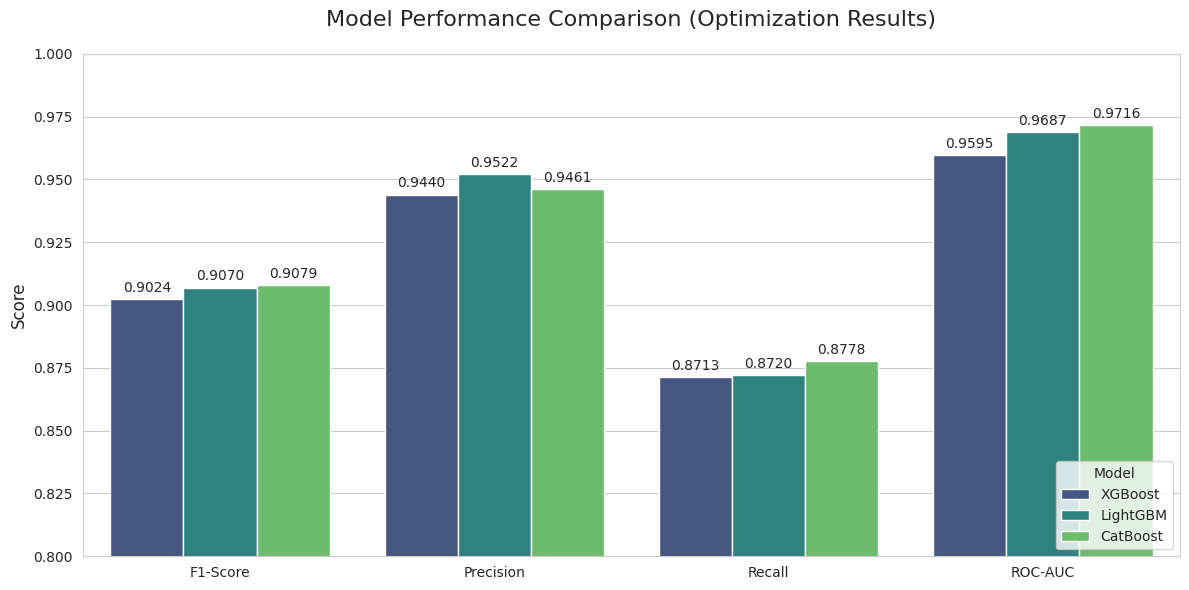

In [101]:
#แสดงผล : กราฟเปรียบเทียบ

import matplotlib.pyplot as plt

# 1. ดึงข้อมูลจาก Study objects
# (สมมติว่าคุณรัน optimization เสร็จแล้วและมีตัวแปร study_xgb10, study_lgbm10, study_cat10 อยู่)
studies_data = [
    {"Model": "XGBoost",  "Study": study_xgb10},
    {"Model": "LightGBM", "Study": study_lgbm10},
    {"Model": "CatBoost", "Study": study_cat10}
]

metrics_list = []

for item in studies_data:
    study = item["Study"]
    best_trial = study.best_trial

    # ดึงค่าจาก user_attrs (ใช้ .get(..., 0) กัน Error กรณีไม่ได้ save ไว้)
    metrics_list.append({
        "Model": item["Model"],
        "F1-Score": study.best_value,
        "Precision": best_trial.user_attrs.get("precision", 0),
        "Recall": best_trial.user_attrs.get("recall", 0),
        "ROC-AUC": best_trial.user_attrs.get("auc", 0)
    })

# 2. แปลงเป็น DataFrame สำหรับ Plot กราฟ
df_metrics = pd.DataFrame(metrics_list)

# แปลงข้อมูลเป็นแนวตั้ง (Long Format) เพื่อให้ง่ายต่อการ plot ด้วย Seaborn
df_melted = df_metrics.melt(id_vars="Model", var_name="Metric", value_name="Score")

# 3. สร้างกราฟ
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# สร้าง Bar Plot
chart = sns.barplot(
    data=df_melted,
    x="Metric",
    y="Score",
    hue="Model",
    palette="viridis" # หรือลอง "deep", "Set2"
)

# 4. ตกแต่งกราฟ
plt.title("Model Performance Comparison (Optimization Results)", fontsize=16, pad=20)
plt.ylim(0.8, 1.0) # ปรับแกน Y ให้เห็นความต่างชัดขึ้น (เพราะคะแนนสูงหมด)
plt.ylabel("Score", fontsize=12)
plt.xlabel("")
plt.legend(title="Model", loc='lower right')

# ใส่ตัวเลขบนแท่งกราฟ
for container in chart.containers:
    chart.bar_label(container, fmt='%.4f', padding=3, fontsize=10)

plt.tight_layout()
plt.show()

### 2.4.2 20% less than nominal

In [67]:
#Run the studies : 20% less than nominal

sampler = optuna.samplers.TPESampler(seed=42)
pruner  = optuna.pruners.MedianPruner(n_warmup_steps=5)

study_xgb20  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="xgb_20_f1")
study_lgbm20 = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="lgbm_20_f1")
study_cat20  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="cat_20_f1")

study_xgb20.optimize(objective_xgb20,  n_trials=30, show_progress_bar=True)
study_lgbm20.optimize(objective_lgbm20, n_trials=30, show_progress_bar=True)
study_cat20.optimize(objective_cat20,   n_trials=30, show_progress_bar=True)

#Run the optimization

print("Best_XGB20_F1:", study_xgb20.best_value, "\nParams:", study_xgb20.best_params, "\nAux:", study_xgb20.best_trial.user_attrs)
print("Best_LGBM20_F1:", study_lgbm20.best_value, "\nParams:", study_lgbm20.best_params, "\nAux:", study_lgbm20.best_trial.user_attrs)
print("Best_CAT20_F1:", study_cat20.best_value, "\nParams:", study_cat20.best_params, "\nAux:", study_cat20.best_trial.user_attrs)



[I 2026-01-23 08:57:15,147] A new study created in memory with name: xgb_20_f1
[I 2026-01-23 08:57:15,148] A new study created in memory with name: lgbm_20_f1
[I 2026-01-23 08:57:15,149] A new study created in memory with name: cat_20_f1


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-23 08:57:17,972] Trial 0 finished with value: 0.9603883720818862 and parameters: {'n_estimators': 425, 'learning_rate': 0.17254716573280354, 'max_depth': 7, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2.403950683025824, 'reg_lambda': 0.2904180608409973, 'reg_alpha': 1.7323522915498704}. Best is trial 0 with value: 0.9603883720818862.
[I 2026-01-23 08:57:21,939] Trial 1 finished with value: 0.9668772366246389 and parameters: {'n_estimators': 561, 'learning_rate': 0.08341106432362087, 'max_depth': 3, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'min_child_weight': 2.9110519961044856, 'reg_lambda': 0.9091248360355031, 'reg_alpha': 0.36680901970686763}. Best is trial 1 with value: 0.9668772366246389.
[I 2026-01-23 08:57:27,198] Trial 2 finished with value: 0.9598381548788943 and parameters: {'n_estimators': 382, 'learning_rate': 0.048164145309070844, 'max_depth': 5, 'subsample': 0.7164916560792167, 'col

  0%|          | 0/30 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-23 09:01:45,776] Trial 0 finished with value: 0.9644408527039836 and parameters: {'iterations': 607, 'learning_rate': 0.010509480845860123, 'depth': 6, 'l2_leaf_reg': 1.1324788759896898, 'bagging_temperature': 3.2258639520472494}. Best is trial 0 with value: 0.9644408527039836.
[I 2026-01-23 09:01:52,809] Trial 1 finished with value: 0.9744246975721914 and parameters: {'iterations': 304, 'learning_rate': 0.07923749226909173, 'depth': 5, 'l2_leaf_reg': 4.6836499436836725, 'bagging_temperature': 0.6876047207299663}. Best is trial 1 with value: 0.9744246975721914.
[I 2026-01-23 09:02:30,086] Trial 2 finished with value: 0.9662061230133627 and parameters: {'iterations': 404, 'learning_rate': 0.014048580838867042, 'depth': 8, 'l2_leaf_reg': 4.386696766904905, 'bagging_temperature': 1.289708138575778}. Best is trial 1 with value: 0.9744246975721914.
[I 2026-01-23 09:02:50,638] Trial 3 finished with value: 0.9550847438899916 and parameters: {'iterations': 596, 'learning_rate': 0.11

In [68]:
#แสดงผล : ตาราง

import pandas as pd

# 1. รวบรวมข้อมูลจากทั้ง 3 Studies
studies_data = [
    {
        "Model": "XGBoost (20%)",
        "Study": study_xgb20
    },
    {
        "Model": "LightGBM (20%)",
        "Study": study_lgbm20
    },
    {
        "Model": "CatBoost (20%)",
        "Study": study_cat20
    }
]

results = []

for item in studies_data:
    study = item["Study"]
    trial = study.best_trial

    # ดึงค่า Metrics (ใช้ .get() เพื่อกัน Error กรณีไม่ได้ save ไว้)
    results.append({
        "Model": item["Model"],
        "F1-Score": study.best_value,
        "Recall": trial.user_attrs.get("recall", 0),
        "Precision": trial.user_attrs.get("precision", 0),
        "ROC-AUC": trial.user_attrs.get("auc", 0),
        "Best Params": trial.params  # เก็บ Params ไว้ด้วยแต่ซ่อนได้
    })

# 2. สร้าง DataFrame
df_results = pd.DataFrame(results)
df_results.set_index("Model", inplace=True)

# 3. แสดงผลแบบตารางสวยงาม (Highlight ค่ามากที่สุดของแต่ละคอลัมน์)
# หมายเหตุ: Params จะยาวมาก ผมเลยเลือกโชว์เฉพาะค่า Metrics หลัก
styled_df = (df_results[["F1-Score", "Recall", "Precision", "ROC-AUC"]]
             .style
             .highlight_max(color='lightgreen', axis=0)  # สีเขียวช่องที่ค่ามากสุด
             .format("{:.4f}")                           # ทศนิยม 4 ตำแหน่ง
             .set_caption("Comparison of Optimized Models (Validation Score)"))

display(styled_df)

# ---------------------------------------------------------
# แถม: ถ้าอยากดู Best Params แบบชัดๆ แยกออกมา
print("\n=== Best Hyperparameters Details ===")
for item in studies_data:
    print(f"\n🔹 {item['Model']}:")
    for key, value in item["Study"].best_params.items():
        print(f"  - {key}: {value}")

,F1-Score,Recall,Precision,ROC-AUC
Model,,,,
XGBoost (20%),0.9754,0.9720,0.9796,0.9876
LightGBM (20%),0.9686,0.9508,0.9877,0.9864
CatBoost (20%),0.9804,0.9799,0.9810,0.9947



=== Best Hyperparameters Details ===

🔹 XGBoost (20%):
  - n_estimators: 540
  - learning_rate: 0.03938877988191454
  - max_depth: 3
  - subsample: 0.6883522143141513
  - colsample_bytree: 0.9602516596911702
  - min_child_weight: 4.1111371649248865
  - reg_lambda: 0.10496408338849905
  - reg_alpha: 1.493721182939615

🔹 LightGBM (20%):
  - n_estimators: 204
  - learning_rate: 0.01126170916454574
  - num_leaves: 22
  - max_depth: 8
  - subsample: 0.6051586310394397
  - colsample_bytree: 0.8429398470641422
  - min_child_samples: 43
  - reg_lambda: 1.4120387038740545
  - reg_alpha: 0.018095641373861396

🔹 CatBoost (20%):
  - iterations: 529
  - learning_rate: 0.1977707626096671
  - depth: 5
  - l2_leaf_reg: 1.637231299040174
  - bagging_temperature: 0.592368519871823


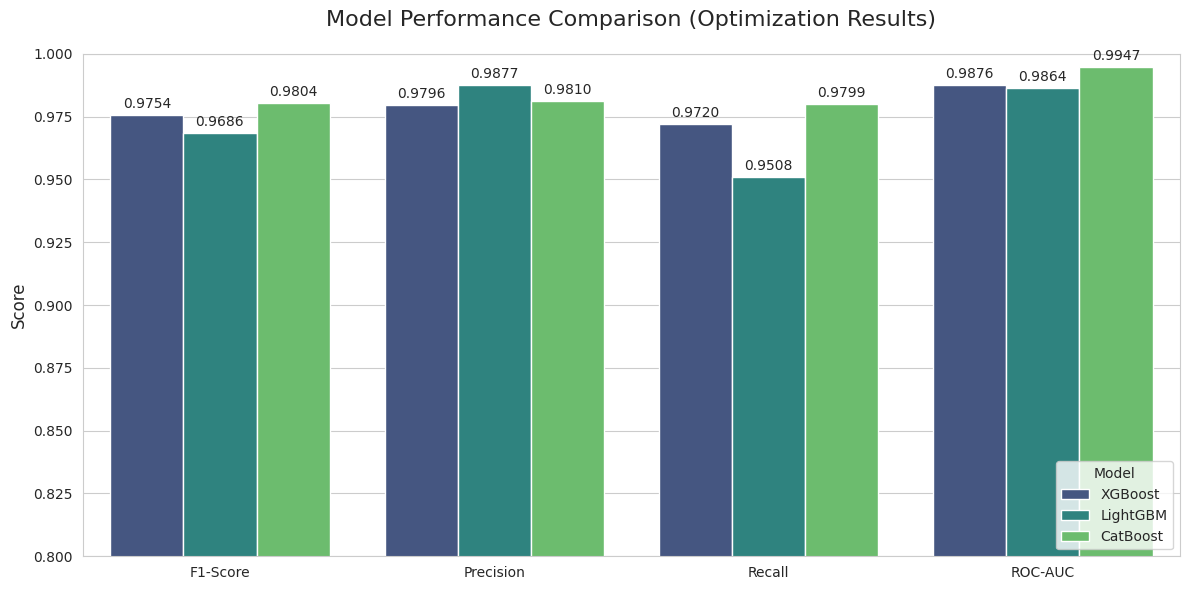

In [69]:
#แสดงผล : กราฟเปรียบเทียบ

import matplotlib.pyplot as plt

# 1. ดึงข้อมูลจาก Study objects
# (สมมติว่าคุณรัน optimization เสร็จแล้วและมีตัวแปร study_xgb20, study_lgbm20, study_cat20 อยู่)
studies_data = [
    {"Model": "XGBoost",  "Study": study_xgb20},
    {"Model": "LightGBM", "Study": study_lgbm20},
    {"Model": "CatBoost", "Study": study_cat20}
]

metrics_list = []

for item in studies_data:
    study = item["Study"]
    best_trial = study.best_trial

    # ดึงค่าจาก user_attrs (ใช้ .get(..., 0) กัน Error กรณีไม่ได้ save ไว้)
    metrics_list.append({
        "Model": item["Model"],
        "F1-Score": study.best_value,
        "Precision": best_trial.user_attrs.get("precision", 0),
        "Recall": best_trial.user_attrs.get("recall", 0),
        "ROC-AUC": best_trial.user_attrs.get("auc", 0)
    })

# 2. แปลงเป็น DataFrame สำหรับ Plot กราฟ
df_metrics = pd.DataFrame(metrics_list)

# แปลงข้อมูลเป็นแนวตั้ง (Long Format) เพื่อให้ง่ายต่อการ plot ด้วย Seaborn
df_melted = df_metrics.melt(id_vars="Model", var_name="Metric", value_name="Score")

# 3. สร้างกราฟ
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# สร้าง Bar Plot
chart = sns.barplot(
    data=df_melted,
    x="Metric",
    y="Score",
    hue="Model",
    palette="viridis" # หรือลอง "deep", "Set2"
)

# 4. ตกแต่งกราฟ
plt.title("Model Performance Comparison (Optimization Results)", fontsize=16, pad=20)
plt.ylim(0.8, 1.0) # ปรับแกน Y ให้เห็นความต่างชัดขึ้น (เพราะคะแนนสูงหมด)
plt.ylabel("Score", fontsize=12)
plt.xlabel("")
plt.legend(title="Model", loc='lower right')

# ใส่ตัวเลขบนแท่งกราฟ
for container in chart.containers:
    chart.bar_label(container, fmt='%.4f', padding=3, fontsize=10)

plt.tight_layout()
plt.show()

### 2.4.3 30% less than nominal

In [70]:
#Run the studies : 30% less than nominal

sampler = optuna.samplers.TPESampler(seed=42)
pruner  = optuna.pruners.MedianPruner(n_warmup_steps=5)

study_xgb30  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="xgb_30_f1")
study_lgbm30 = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="lgbm_30_f1")
study_cat30  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="cat_30_f1")

study_xgb30.optimize(objective_xgb30,  n_trials=30, show_progress_bar=True)
study_lgbm30.optimize(objective_lgbm30, n_trials=30, show_progress_bar=True)
study_cat30.optimize(objective_cat30,   n_trials=30, show_progress_bar=True)

#Run the optimization

print("Best_XGB30_F1:", study_xgb30.best_value, "\nParams:", study_xgb30.best_params, "\nAux:", study_xgb30.best_trial.user_attrs)
print("Best_LGBM30_F1:", study_lgbm30.best_value, "\nParams:", study_lgbm30.best_params, "\nAux:", study_lgbm30.best_trial.user_attrs)
print("Best_CAT30_F1:", study_cat30.best_value, "\nParams:", study_cat30.best_params, "\nAux:", study_cat30.best_trial.user_attrs)



[I 2026-01-23 09:15:21,228] A new study created in memory with name: xgb_30_f1
[I 2026-01-23 09:15:21,229] A new study created in memory with name: lgbm_30_f1
[I 2026-01-23 09:15:21,230] A new study created in memory with name: cat_30_f1


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-23 09:15:25,474] Trial 0 finished with value: 0.917565573659829 and parameters: {'n_estimators': 425, 'learning_rate': 0.17254716573280354, 'max_depth': 7, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2.403950683025824, 'reg_lambda': 0.2904180608409973, 'reg_alpha': 1.7323522915498704}. Best is trial 0 with value: 0.917565573659829.
[I 2026-01-23 09:15:29,443] Trial 1 finished with value: 0.9259502190230574 and parameters: {'n_estimators': 561, 'learning_rate': 0.08341106432362087, 'max_depth': 3, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'min_child_weight': 2.9110519961044856, 'reg_lambda': 0.9091248360355031, 'reg_alpha': 0.36680901970686763}. Best is trial 1 with value: 0.9259502190230574.
[I 2026-01-23 09:15:33,219] Trial 2 finished with value: 0.922122455338285 and parameters: {'n_estimators': 382, 'learning_rate': 0.048164145309070844, 'max_depth': 5, 'subsample': 0.7164916560792167, 'colsam

  0%|          | 0/30 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-23 09:20:28,865] Trial 0 finished with value: 0.938666740138833 and parameters: {'iterations': 607, 'learning_rate': 0.010509480845860123, 'depth': 6, 'l2_leaf_reg': 1.1324788759896898, 'bagging_temperature': 3.2258639520472494}. Best is trial 0 with value: 0.938666740138833.
[I 2026-01-23 09:20:37,010] Trial 1 finished with value: 0.9397340274218763 and parameters: {'iterations': 304, 'learning_rate': 0.07923749226909173, 'depth': 5, 'l2_leaf_reg': 4.6836499436836725, 'bagging_temperature': 0.6876047207299663}. Best is trial 1 with value: 0.9397340274218763.
[I 2026-01-23 09:21:14,144] Trial 2 finished with value: 0.9394829858905638 and parameters: {'iterations': 404, 'learning_rate': 0.014048580838867042, 'depth': 8, 'l2_leaf_reg': 4.386696766904905, 'bagging_temperature': 1.289708138575778}. Best is trial 1 with value: 0.9397340274218763.
[I 2026-01-23 09:21:34,811] Trial 3 finished with value: 0.9421250366892799 and parameters: {'iterations': 596, 'learning_rate': 0.1156

In [71]:
#แสดงผล : ตาราง

import pandas as pd

# 1. รวบรวมข้อมูลจากทั้ง 3 Studies
studies_data = [
    {
        "Model": "XGBoost (30%)",
        "Study": study_xgb30
    },
    {
        "Model": "LightGBM (30%)",
        "Study": study_lgbm30
    },
    {
        "Model": "CatBoost (30%)",
        "Study": study_cat30
    }
]

results = []

for item in studies_data:
    study = item["Study"]
    trial = study.best_trial

    # ดึงค่า Metrics (ใช้ .get() เพื่อกัน Error กรณีไม่ได้ save ไว้)
    results.append({
        "Model": item["Model"],
        "F1-Score": study.best_value,
        "Recall": trial.user_attrs.get("recall", 0),
        "Precision": trial.user_attrs.get("precision", 0),
        "ROC-AUC": trial.user_attrs.get("auc", 0),
        "Best Params": trial.params  # เก็บ Params ไว้ด้วยแต่ซ่อนได้
    })

# 2. สร้าง DataFrame
df_results = pd.DataFrame(results)
df_results.set_index("Model", inplace=True)

# 3. แสดงผลแบบตารางสวยงาม (Highlight ค่ามากที่สุดของแต่ละคอลัมน์)
# หมายเหตุ: Params จะยาวมาก ผมเลยเลือกโชว์เฉพาะค่า Metrics หลัก
styled_df = (df_results[["F1-Score", "Recall", "Precision", "ROC-AUC"]]
             .style
             .highlight_max(color='lightgreen', axis=0)  # สีเขียวช่องที่ค่ามากสุด
             .format("{:.4f}")                           # ทศนิยม 4 ตำแหน่ง
             .set_caption("Comparison of Optimized Models (Validation Score)"))

display(styled_df)

# ---------------------------------------------------------
# แถม: ถ้าอยากดู Best Params แบบชัดๆ แยกออกมา
print("\n=== Best Hyperparameters Details ===")
for item in studies_data:
    print(f"\n🔹 {item['Model']}:")
    for key, value in item["Study"].best_params.items():
        print(f"  - {key}: {value}")

,F1-Score,Recall,Precision,ROC-AUC
Model,,,,
XGBoost (30%),0.9327,0.9517,0.9203,0.9868
LightGBM (30%),0.9320,0.9628,0.9089,0.9897
CatBoost (30%),0.9490,0.9703,0.9309,0.9879



=== Best Hyperparameters Details ===

🔹 XGBoost (30%):
  - n_estimators: 400
  - learning_rate: 0.12370877689290724
  - max_depth: 4
  - subsample: 0.6549612269166183
  - colsample_bytree: 0.9522533444481311
  - min_child_weight: 2.805416559168208
  - reg_lambda: 3.2986929713708695
  - reg_alpha: 0.5542734649833413

🔹 LightGBM (30%):
  - n_estimators: 707
  - learning_rate: 0.057275829287293446
  - num_leaves: 26
  - max_depth: 8
  - subsample: 0.7215904196458885
  - colsample_bytree: 0.9272835859742584
  - min_child_samples: 31
  - reg_lambda: 4.988326923310148
  - reg_alpha: 1.4432866023755504

🔹 CatBoost (30%):
  - iterations: 673
  - learning_rate: 0.195892842381047
  - depth: 4
  - l2_leaf_reg: 3.7269587596316427
  - bagging_temperature: 2.5265962537247617


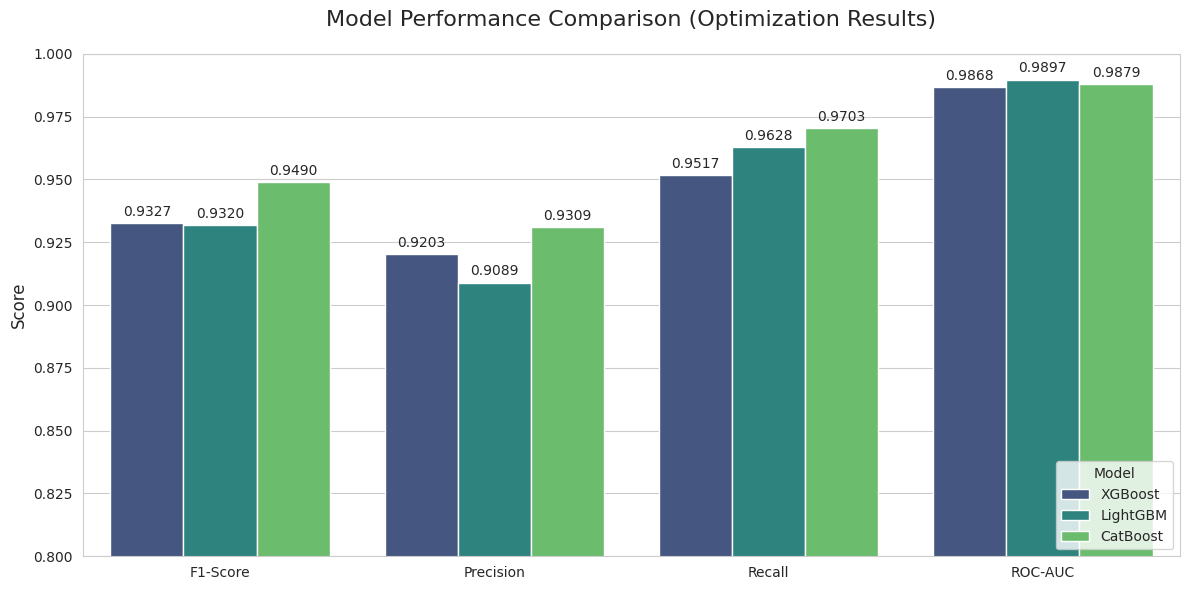

In [72]:
#แสดงผล : กราฟเปรียบเทียบ

import matplotlib.pyplot as plt

# 1. ดึงข้อมูลจาก Study objects
# (สมมติว่าคุณรัน optimization เสร็จแล้วและมีตัวแปร study_xgb30, study_lgbm30, study_cat30 อยู่)
studies_data = [
    {"Model": "XGBoost",  "Study": study_xgb30},
    {"Model": "LightGBM", "Study": study_lgbm30},
    {"Model": "CatBoost", "Study": study_cat30}
]

metrics_list = []

for item in studies_data:
    study = item["Study"]
    best_trial = study.best_trial

    # ดึงค่าจาก user_attrs (ใช้ .get(..., 0) กัน Error กรณีไม่ได้ save ไว้)
    metrics_list.append({
        "Model": item["Model"],
        "F1-Score": study.best_value,
        "Precision": best_trial.user_attrs.get("precision", 0),
        "Recall": best_trial.user_attrs.get("recall", 0),
        "ROC-AUC": best_trial.user_attrs.get("auc", 0)
    })

# 2. แปลงเป็น DataFrame สำหรับ Plot กราฟ
df_metrics = pd.DataFrame(metrics_list)

# แปลงข้อมูลเป็นแนวตั้ง (Long Format) เพื่อให้ง่ายต่อการ plot ด้วย Seaborn
df_melted = df_metrics.melt(id_vars="Model", var_name="Metric", value_name="Score")

# 3. สร้างกราฟ
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# สร้าง Bar Plot
chart = sns.barplot(
    data=df_melted,
    x="Metric",
    y="Score",
    hue="Model",
    palette="viridis" # หรือลอง "deep", "Set2"
)

# 4. ตกแต่งกราฟ
plt.title("Model Performance Comparison (Optimization Results)", fontsize=16, pad=20)
plt.ylim(0.8, 1.0) # ปรับแกน Y ให้เห็นความต่างชัดขึ้น (เพราะคะแนนสูงหมด)
plt.ylabel("Score", fontsize=12)
plt.xlabel("")
plt.legend(title="Model", loc='lower right')

# ใส่ตัวเลขบนแท่งกราฟ
for container in chart.containers:
    chart.bar_label(container, fmt='%.4f', padding=3, fontsize=10)

plt.tight_layout()
plt.show()

### 2.4.4 40% less than nominal

In [73]:
#Run the studies : 40% less than nominal

sampler = optuna.samplers.TPESampler(seed=42)
pruner  = optuna.pruners.MedianPruner(n_warmup_steps=5)

study_xgb40  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="xgb_40_f1")
study_lgbm40 = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="lgbm_40_f1")
study_cat40  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="cat_40_f1")

study_xgb40.optimize(objective_xgb40,  n_trials=30, show_progress_bar=True)
study_lgbm40.optimize(objective_lgbm40, n_trials=30, show_progress_bar=True)
study_cat40.optimize(objective_cat40,   n_trials=30, show_progress_bar=True)

#Run the optimization

print("Best_XGB40_F1:", study_xgb40.best_value, "\nParams:", study_xgb40.best_params, "\nAux:", study_xgb40.best_trial.user_attrs)
print("Best_LGBM40_F1:", study_lgbm40.best_value, "\nParams:", study_lgbm40.best_params, "\nAux:", study_lgbm40.best_trial.user_attrs)
print("Best_CAT40_F1:", study_cat40.best_value, "\nParams:", study_cat40.best_params, "\nAux:", study_cat40.best_trial.user_attrs)



[I 2026-01-23 09:33:24,512] A new study created in memory with name: xgb_40_f1
[I 2026-01-23 09:33:24,513] A new study created in memory with name: lgbm_40_f1
[I 2026-01-23 09:33:24,516] A new study created in memory with name: cat_40_f1


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-23 09:33:26,694] Trial 0 finished with value: 0.9997690092259844 and parameters: {'n_estimators': 425, 'learning_rate': 0.17254716573280354, 'max_depth': 7, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2.403950683025824, 'reg_lambda': 0.2904180608409973, 'reg_alpha': 1.7323522915498704}. Best is trial 0 with value: 0.9997690092259844.
[I 2026-01-23 09:33:29,311] Trial 1 finished with value: 0.9997690092259844 and parameters: {'n_estimators': 561, 'learning_rate': 0.08341106432362087, 'max_depth': 3, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'min_child_weight': 2.9110519961044856, 'reg_lambda': 0.9091248360355031, 'reg_alpha': 0.36680901970686763}. Best is trial 0 with value: 0.9997690092259844.
[I 2026-01-23 09:33:31,584] Trial 2 finished with value: 0.9997690092259844 and parameters: {'n_estimators': 382, 'learning_rate': 0.048164145309070844, 'max_depth': 5, 'subsample': 0.7164916560792167, 'col

  0%|          | 0/30 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-23 09:37:17,274] Trial 0 finished with value: 0.9998794454490657 and parameters: {'iterations': 607, 'learning_rate': 0.010509480845860123, 'depth': 6, 'l2_leaf_reg': 1.1324788759896898, 'bagging_temperature': 3.2258639520472494}. Best is trial 0 with value: 0.9998794454490657.
[I 2026-01-23 09:37:23,926] Trial 1 finished with value: 0.9998794454490657 and parameters: {'iterations': 304, 'learning_rate': 0.07923749226909173, 'depth': 5, 'l2_leaf_reg': 4.6836499436836725, 'bagging_temperature': 0.6876047207299663}. Best is trial 0 with value: 0.9998794454490657.
[I 2026-01-23 09:37:57,865] Trial 2 finished with value: 0.9998794454490657 and parameters: {'iterations': 404, 'learning_rate': 0.014048580838867042, 'depth': 8, 'l2_leaf_reg': 4.386696766904905, 'bagging_temperature': 1.289708138575778}. Best is trial 0 with value: 0.9998794454490657.
[I 2026-01-23 09:38:18,290] Trial 3 finished with value: 0.9998794454490657 and parameters: {'iterations': 596, 'learning_rate': 0.11

In [74]:
#แสดงผล : ตาราง

import pandas as pd

# 1. รวบรวมข้อมูลจากทั้ง 3 Studies
studies_data = [
    {
        "Model": "XGBoost (40%)",
        "Study": study_xgb40
    },
    {
        "Model": "LightGBM (40%)",
        "Study": study_lgbm40
    },
    {
        "Model": "CatBoost (40%)",
        "Study": study_cat40
    }
]

results = []

for item in studies_data:
    study = item["Study"]
    trial = study.best_trial

    # ดึงค่า Metrics (ใช้ .get() เพื่อกัน Error กรณีไม่ได้ save ไว้)
    results.append({
        "Model": item["Model"],
        "F1-Score": study.best_value,
        "Recall": trial.user_attrs.get("recall", 0),
        "Precision": trial.user_attrs.get("precision", 0),
        "ROC-AUC": trial.user_attrs.get("auc", 0),
        "Best Params": trial.params  # เก็บ Params ไว้ด้วยแต่ซ่อนได้
    })

# 2. สร้าง DataFrame
df_results = pd.DataFrame(results)
df_results.set_index("Model", inplace=True)

# 3. แสดงผลแบบตารางสวยงาม (Highlight ค่ามากที่สุดของแต่ละคอลัมน์)
# หมายเหตุ: Params จะยาวมาก ผมเลยเลือกโชว์เฉพาะค่า Metrics หลัก
styled_df = (df_results[["F1-Score", "Recall", "Precision", "ROC-AUC"]]
             .style
             .highlight_max(color='lightgreen', axis=0)  # สีเขียวช่องที่ค่ามากสุด
             .format("{:.4f}")                           # ทศนิยม 4 ตำแหน่ง
             .set_caption("Comparison of Optimized Models (Validation Score)"))

display(styled_df)

# ---------------------------------------------------------
# แถม: ถ้าอยากดู Best Params แบบชัดๆ แยกออกมา
print("\n=== Best Hyperparameters Details ===")
for item in studies_data:
    print(f"\n🔹 {item['Model']}:")
    for key, value in item["Study"].best_params.items():
        print(f"  - {key}: {value}")

,F1-Score,Recall,Precision,ROC-AUC
Model,,,,
XGBoost (40%),0.9999,0.9998,1.0000,1.0000
LightGBM (40%),0.9999,0.9998,1.0000,1.0000
CatBoost (40%),0.9999,0.9998,1.0000,1.0000



=== Best Hyperparameters Details ===

🔹 XGBoost (40%):
  - n_estimators: 738
  - learning_rate: 0.010181283131439633
  - max_depth: 6
  - subsample: 0.6071847502459279
  - colsample_bytree: 0.6061470949312417
  - min_child_weight: 4.942728347156469
  - reg_lambda: 0.0757211855137844
  - reg_alpha: 1.9522797997159904

🔹 LightGBM (40%):
  - n_estimators: 718
  - learning_rate: 0.06470376604234768
  - num_leaves: 26
  - max_depth: 3
  - subsample: 0.7243929286862649
  - colsample_bytree: 0.7300733288106989
  - min_child_samples: 47
  - reg_lambda: 3.1877873567760657
  - reg_alpha: 1.774425485152653

🔹 CatBoost (40%):
  - iterations: 607
  - learning_rate: 0.010509480845860123
  - depth: 6
  - l2_leaf_reg: 1.1324788759896898
  - bagging_temperature: 3.2258639520472494


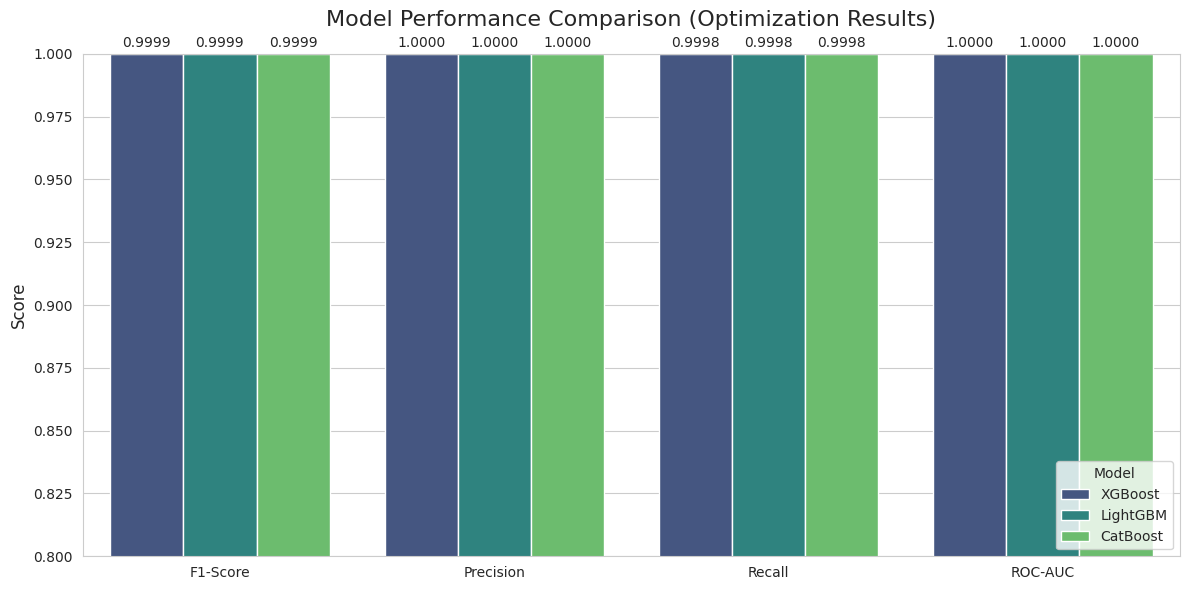

In [75]:
#แสดงผล : กราฟเปรียบเทียบ

import matplotlib.pyplot as plt

# 1. ดึงข้อมูลจาก Study objects
# (สมมติว่าคุณรัน optimization เสร็จแล้วและมีตัวแปร study_xgb40, study_lgbm40, study_cat40 อยู่)
studies_data = [
    {"Model": "XGBoost",  "Study": study_xgb40},
    {"Model": "LightGBM", "Study": study_lgbm40},
    {"Model": "CatBoost", "Study": study_cat40}
]

metrics_list = []

for item in studies_data:
    study = item["Study"]
    best_trial = study.best_trial

    # ดึงค่าจาก user_attrs (ใช้ .get(..., 0) กัน Error กรณีไม่ได้ save ไว้)
    metrics_list.append({
        "Model": item["Model"],
        "F1-Score": study.best_value,
        "Precision": best_trial.user_attrs.get("precision", 0),
        "Recall": best_trial.user_attrs.get("recall", 0),
        "ROC-AUC": best_trial.user_attrs.get("auc", 0)
    })

# 2. แปลงเป็น DataFrame สำหรับ Plot กราฟ
df_metrics = pd.DataFrame(metrics_list)

# แปลงข้อมูลเป็นแนวตั้ง (Long Format) เพื่อให้ง่ายต่อการ plot ด้วย Seaborn
df_melted = df_metrics.melt(id_vars="Model", var_name="Metric", value_name="Score")

# 3. สร้างกราฟ
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# สร้าง Bar Plot
chart = sns.barplot(
    data=df_melted,
    x="Metric",
    y="Score",
    hue="Model",
    palette="viridis" # หรือลอง "deep", "Set2"
)

# 4. ตกแต่งกราฟ
plt.title("Model Performance Comparison (Optimization Results)", fontsize=16, pad=20)
plt.ylim(0.8, 1.0) # ปรับแกน Y ให้เห็นความต่างชัดขึ้น (เพราะคะแนนสูงหมด)
plt.ylabel("Score", fontsize=12)
plt.xlabel("")
plt.legend(title="Model", loc='lower right')

# ใส่ตัวเลขบนแท่งกราฟ
for container in chart.containers:
    chart.bar_label(container, fmt='%.4f', padding=3, fontsize=10)

plt.tight_layout()
plt.show()

### 2.4.5 Save models

In [114]:
# 2. รวบรวมตัวแปร Study ทั้งหมดเข้า Dictionary
# จัดโครงสร้างเป็น

all_studies = {
    "10": {
        "xgb": study_xgb10,
        "lgbm": study_lgbm10,
        "cat": study_cat10
    },
    "20": {
        "xgb": study_xgb20,
        "lgbm": study_lgbm20,
        "cat": study_cat20
    },
    "30": {
        "xgb": study_xgb30,
        "lgbm": study_lgbm30,
        "cat": study_cat30
    },
    "40": {
        "xgb": study_xgb40,
        "lgbm": study_lgbm40,
        "cat": study_cat40
    }
}

# 3. กำหนด Path ปลายทาง
save_dir = '/content/drive/MyDrive/saved_studies'
file_path = os.path.join(save_dir, 'optuna_studies_all.pkl')

# 4. สร้างโฟลเดอร์หากยังไม่มี
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory: {save_dir}")

# 5. บันทึกลงไฟล์
print(f"Saving all studies to {file_path} ...")
joblib.dump(all_studies, file_path)

print("SAVE COMPLETE")
print(f"   Location: {file_path}")

Saving all studies to /content/drive/MyDrive/saved_studies/optuna_studies_all.pkl ...
SAVE COMPLETE
   Location: /content/drive/MyDrive/saved_studies/optuna_studies_all.pkl


# 3.Data visualization

In [76]:
#Import libraries

import shap
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

## 3.1 Comparison of 4 models performance

F1-Score Comparison Table


Model,CatBoost,LightGBM,XGBoost
Dataset,,,
10%,0.9079,0.9070,0.9024
20%,0.9804,0.9686,0.9754
30%,0.9490,0.9320,0.9327
40%,0.9999,0.9999,0.9999


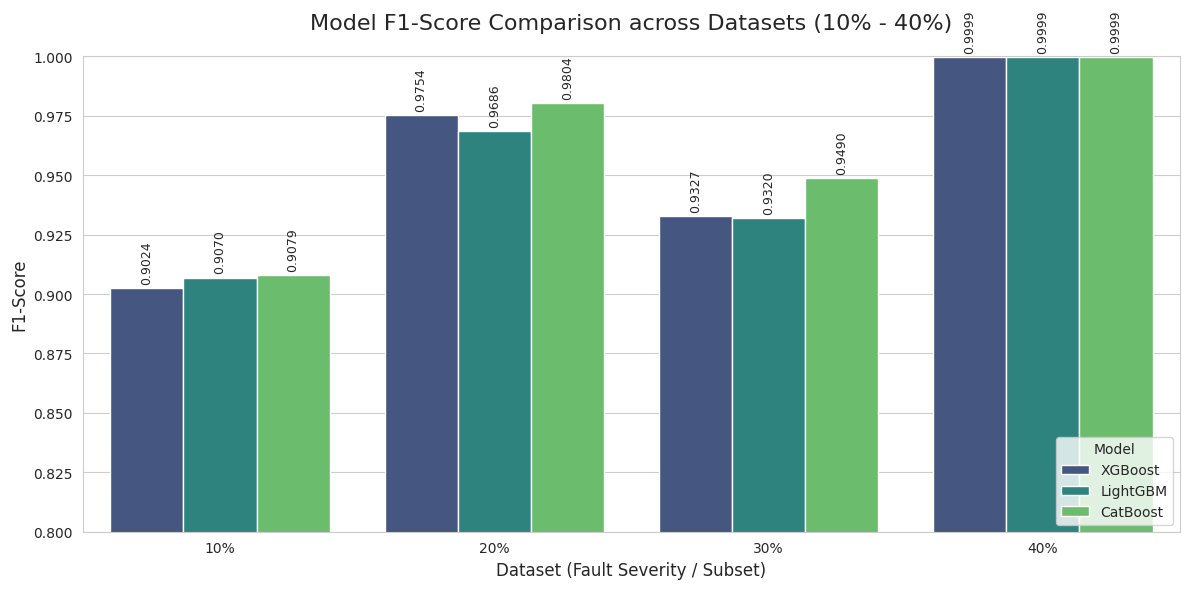

In [102]:
# 1. รวบรวมข้อมูลจาก Study Objects ทั้งหมด
# เราจะจัดกลุ่มตาม Dataset (10, 20, 30, 40) และ Model Type
data = []

# สร้าง List เก็บข้อมูล Configuration
scenarios = [
    ("10%", study_xgb10, study_lgbm10, study_cat10),
    ("20%", study_xgb20, study_lgbm20, study_cat20),
    ("30%", study_xgb30, study_lgbm30, study_cat30),
    ("40%", study_xgb40, study_lgbm40, study_cat40)
]

for label, s_xgb, s_lgbm, s_cat in scenarios:
    # XGBoost
    data.append({
        "Dataset": label,
        "Model": "XGBoost",
        "F1-Score": s_xgb.best_value
    })
    # LightGBM
    data.append({
        "Dataset": label,
        "Model": "LightGBM",
        "F1-Score": s_lgbm.best_value
    })
    # CatBoost
    data.append({
        "Dataset": label,
        "Model": "CatBoost",
        "F1-Score": s_cat.best_value
    })

# 2. สร้าง DataFrame
df_compare = pd.DataFrame(data)

# 3. แสดงตารางเปรียบเทียบ (Pivot Table)
print("F1-Score Comparison Table")
pivot_table = df_compare.pivot(index="Dataset", columns="Model", values="F1-Score")
# จัดรูปแบบให้สวยงาม (แสดงทศนิยม 4 ตำแหน่ง)
display(pivot_table.style.highlight_max(axis=1, color='lightgreen').format("{:.4f}"))

# 4. พล็อตกราฟ Grouped Bar Chart
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# สร้างกราฟแท่งเปรียบเทียบ
chart = sns.barplot(
    data=df_compare,
    x="Dataset",
    y="F1-Score",
    hue="Model",
    palette="viridis"
)

# ตกแต่งกราฟ
plt.title("Model F1-Score Comparison across Datasets (10% - 40%)", fontsize=16, pad=20)
plt.ylabel("F1-Score", fontsize=12)
plt.xlabel("Dataset (Fault Severity / Subset)", fontsize=12)
plt.ylim(0.80, 1.0) # ปรับแกน Y ให้เห็นความต่างชัดขึ้น (เพราะคะแนนน่าจะสูง)
plt.legend(title="Model", loc='lower right')

# ใส่ตัวเลขบนแท่งกราฟ
for container in chart.containers:
    chart.bar_label(container, fmt='%.4f', padding=3, fontsize=9, rotation=90)

plt.tight_layout()
plt.show()

## 4.1 Feature importance

Retraining XGBoost with best parameters...


/tmp/ipython-input-2099914321.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


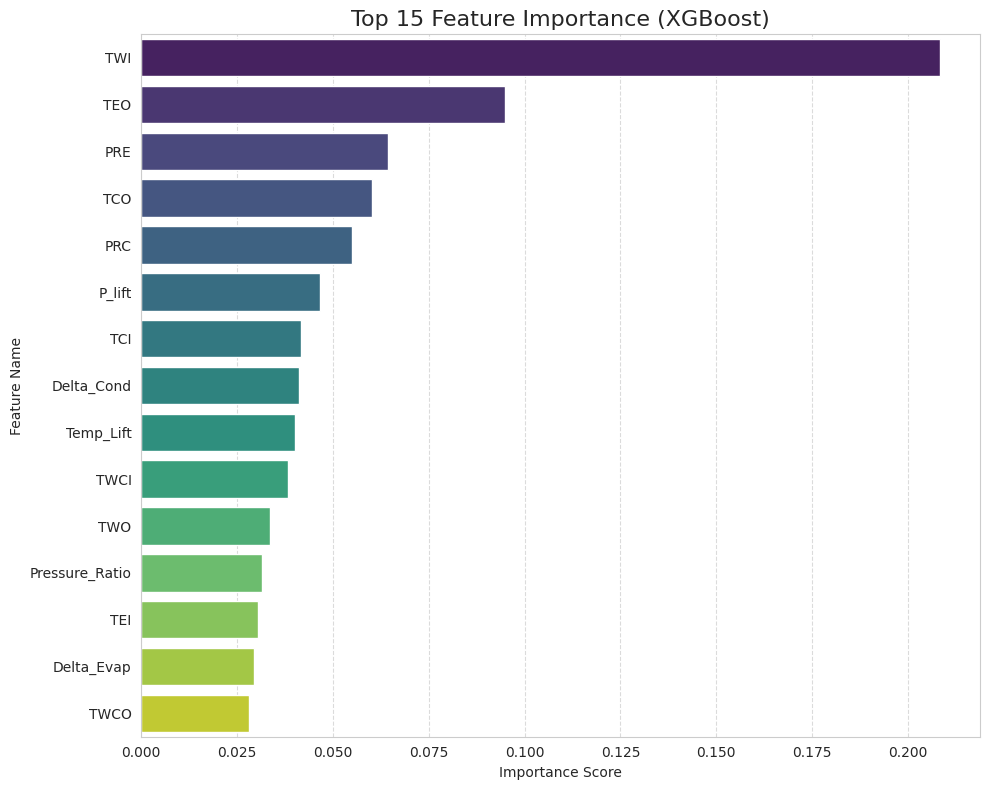

In [103]:
#หา feature importance เฉพาะจากโมเดล xgb

# 1. ดึง Best Params ออกมา
best_params = study_xgb10.best_params

# สำคัญ: ต้องเพิ่มค่า Fixed Parameters ที่เราไม่ได้จูนใน Optuna กลับเข้าไปด้วย
# (อ้างอิงจาก code objective_xgb10 ก่อนหน้านี้)
best_params.update({
    "random_state": 42,
    "tree_method": "hist",
    "eval_metric": "logloss",
    # "scale_pos_weight": ... # (ถ้าคุณเปิดใช้บรรทัดนี้ใน objective ก็ต้องใส่ค่าเดิมตรงนี้ด้วย)
})

# 2. สร้างโมเดลและ Retrain ใหม่
print("Retraining XGBoost with best parameters...")
best_xgb = XGBClassifier(**best_params)
best_xgb.fit(X_tr10, y_tr10)

# 3. ดึงค่า Feature Importance
importance_values = best_xgb.feature_importances_
feature_names = X_tr10.columns

# สร้าง DataFrame เพื่อจัดการข้อมูล
df_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importance_values
}).sort_values(by="Importance", ascending=False)

# 4. พล็อตลงกราฟ (แสดง Top 15 Features)
plt.figure(figsize=(10, 8))
sns.barplot(
    data=df_imp.head(15), # เลือกดูแค่ 15 ตัวแรกจะได้ไม่อัดแน่นเกินไป
    x="Importance",
    y="Feature",
    palette="viridis" #"deep"
)

plt.title("Top 15 Feature Importance (XGBoost)", fontsize=16)
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [104]:
# ปริ้นท์ดูค่าเป็นตัวเลข
print("\n=== Top 10 Most Important Features ===")

df_imp.head(10)


=== Top 10 Most Important Features ===


,Feature,Importance
2,TWI,0.208357
1,TEO,0.094802
8,PRE,0.064377
5,TCO,0.060132
9,PRC,0.054975
10,P_lift,0.046729
4,TCI,0.041712
20,Delta_Cond,0.041271
21,Temp_Lift,0.040049
6,TWCI,0.038334


In [116]:
#Find best model and retrain from best.model

# 1. รวบรวมผู้เข้าแข่งขันทั้งหมด 12 โมเดล
# (Format: ชื่อโมเดล, ชื่อ Dataset, ตัวแปร Study)
candidates = [
    # Dataset 10%
    ("XGBoost", "10", study_xgb10), ("LightGBM", "10", study_lgbm10), ("CatBoost", "10", study_cat10),
    # Dataset 20%
    ("XGBoost", "20", study_xgb20), ("LightGBM", "20", study_lgbm20), ("CatBoost", "20", study_cat20),
    # Dataset 30%
    ("XGBoost", "30", study_xgb30), ("LightGBM", "30", study_lgbm30), ("CatBoost", "30", study_cat30),
    # Dataset 40%
    ("XGBoost", "40", study_xgb40), ("LightGBM", "40", study_lgbm40), ("CatBoost", "40", study_cat40),
]

# 2. ค้นหาผู้ชนะ (The Best F1-Score)
best_score = -1
winner = None

for model_name, dataset_sev, study in candidates:
    if study.best_value > best_score:
        best_score = study.best_value
        winner = {
            "model_name": model_name,
            "dataset": dataset_sev,
            "study": study
        }

print(f"[1] WINNER MODEL: {winner['model_name']} (Dataset {winner['dataset']}%)")
print(f"[2] Best F1-Score: {best_score:.4f}")

# 3. เตรียมข้อมูลสำหรับ Retrain (เลือก X_tr, y_tr ให้ตรงกับ Dataset ผู้ชนะ)
# (สมมติว่าคุณมีตัวแปร X_tr10, y_tr10, X_tr20... อยู่ใน Memory แล้ว)
data_map = {
    "10": (X_tr10, y_tr10),
    "20": (X_tr20, y_tr20),
    "30": (X_tr30, y_tr30),
    "40": (X_tr40, y_tr40)
}

X_train_winner, y_train_winner = data_map[winner['dataset']]
best_params = winner['study'].best_params.copy()

# 4. สร้างโมเดลและ Retrain
print(f"[3] Retraining {winner['model_name']} on Dataset {winner['dataset']}% to extract importance...")

model = None
if winner['model_name'] == "XGBoost":
    # เพิ่ม fixed params ของ XGB
    best_params.update({"random_state": 42, "tree_method": "hist", "eval_metric": "logloss"})
    model = XGBClassifier(**best_params)

elif winner['model_name'] == "LightGBM":
    # เพิ่ม fixed params ของ LGBM
    best_params.update({"random_state": 42, "verbose": -1})
    model = LGBMClassifier(**best_params)

elif winner['model_name'] == "CatBoost":
    # เพิ่ม fixed params ของ CatBoost
    best_params.update({"random_seed": 42, "verbose": False, "allow_writing_files": False})
    model = CatBoostClassifier(**best_params)

# Fit โมเดล
model.fit(X_train_winner, y_train_winner)

[1] WINNER MODEL: XGBoost (Dataset 40%)
[2] Best F1-Score: 0.9999
[3] Retraining XGBoost on Dataset 40% to extract importance...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6061470949312417, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.010181283131439633,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=4.942728347156469, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=738,
              n_jobs=None, num_parallel_tree=None, ...)

/tmp/ipython-input-3043785766.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


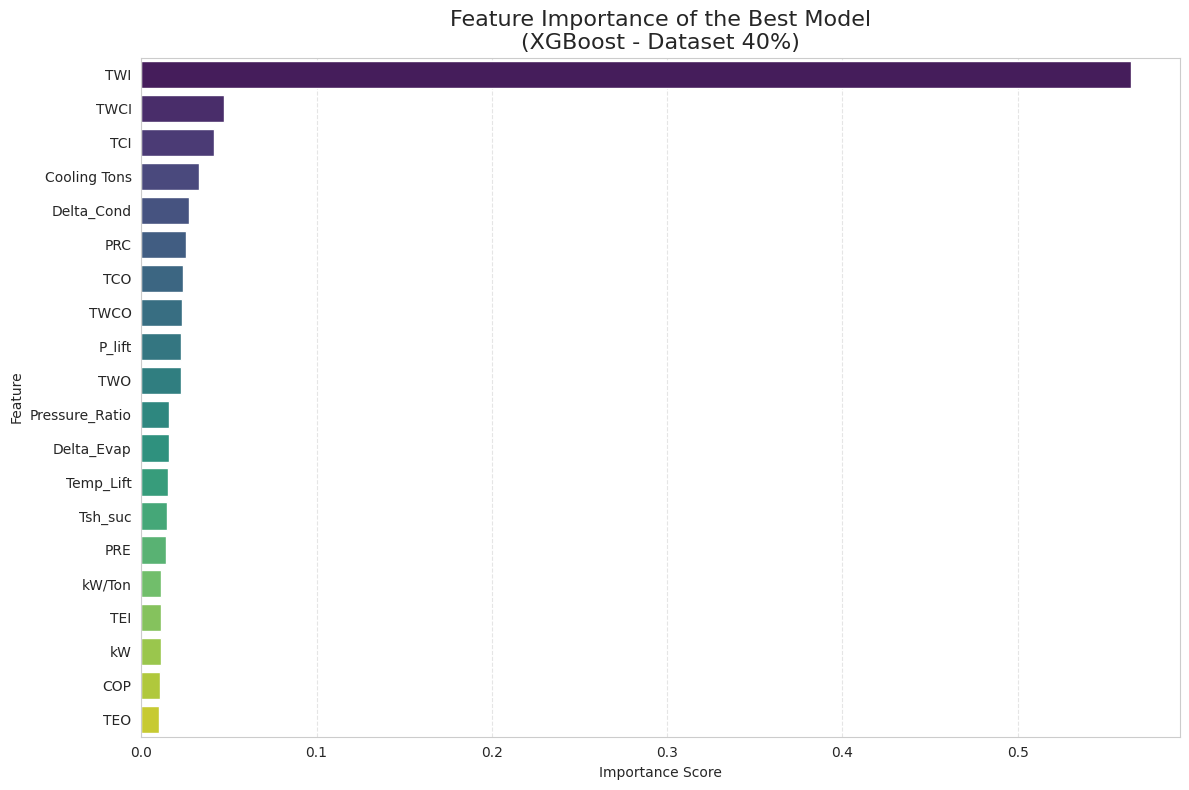


Top 10 Most Important Features


,Feature,Importance
2,TWI,0.564446
6,TWCI,0.047263
4,TCI,0.041744
13,Cooling Tons,0.033103
20,Delta_Cond,0.026997
9,PRC,0.025407
5,TCO,0.023965
7,TWCO,0.023306
10,P_lift,0.022611
3,TWO,0.022603


In [118]:
#Find feature importance from best.model

if winner['model_name'] == "CatBoost":
    importances = model.get_feature_importance()
else:
    importances = model.feature_importances_

feature_names = X_train_winner.columns

# สร้าง DataFrame
df_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# 6. พล็อตกราฟ
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_imp.head(20), # แสดง Top 20 Features
    x="Importance",
    y="Feature",
    palette="viridis"
)

plt.title(f"Feature Importance of the Best Model\n({winner['model_name']} - Dataset {winner['dataset']}%)", fontsize=16)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# แสดงค่า Top 10 เป็นตัวเลข
print("\nTop 10 Most Important Features")
df_imp.head(10)

Calculating Feature Ranks for all models

Model Consistency Check (Spearman Correlation)
           XGBoost  LightGBM  CatBoost
XGBoost   1.000000  0.592308  0.656923
LightGBM  0.592308  1.000000  0.757692
CatBoost  0.656923  0.757692  1.000000


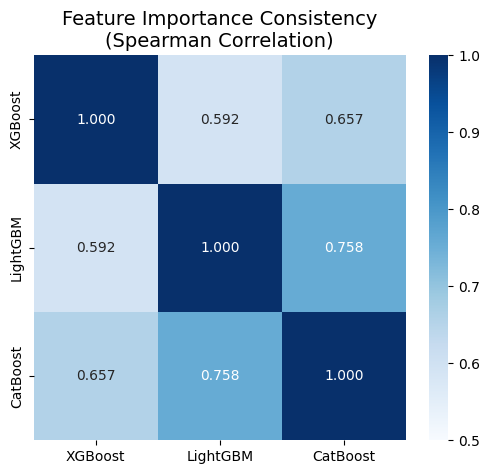

In [67]:
#import pandas as pd
#import seaborn as sns
#import matplotlib.pyplot as plt
from scipy.stats import spearmanr
#from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier

# 1. ฟังก์ชันดึง Rank ของ Feature
def get_feature_ranks(model_name, study, X, y):
    # เตรียมโมเดล
    params = study.best_params.copy()

    if model_name == "XGBoost":
        params.update({"random_state": 42, "tree_method": "hist", "eval_metric": "logloss"})
        model = XGBClassifier(**params)
    elif model_name == "LightGBM":
        params.update({"random_state": 42, "verbose": -1})
        model = LGBMClassifier(**params)
    elif model_name == "CatBoost":
        params.update({"random_seed": 42, "verbose": False, "allow_writing_files": False})
        model = CatBoostClassifier(**params)

    # เทรน
    model.fit(X, y)

    # ดึง Importance
    if model_name == "CatBoost":
        imps = model.get_feature_importance()
    else:
        imps = model.feature_importances_

    return pd.Series(imps, index=X.columns).rank(ascending=False) # แปลงเป็นอันดับ (1, 2, 3...)

# 2. คำนวณ Rank ของทั้ง 3 โมเดล (ใช้ข้อมูลชุด 10% เป็นหลัก)
print("Calculating Feature Ranks for all models")
rank_xgb = get_feature_ranks("XGBoost", study_xgb10, X_tr10, y_tr10)
rank_lgbm = get_feature_ranks("LightGBM", study_lgbm10, X_tr10, y_tr10)
rank_cat = get_feature_ranks("CatBoost", study_cat10, X_tr10, y_tr10)

# 3. สร้าง DataFrame รวม
df_ranks = pd.DataFrame({
    "XGBoost": rank_xgb,
    "LightGBM": rank_lgbm,
    "CatBoost": rank_cat
})

# 4. คำนวณ Spearman Correlation (ดูความสัมพันธ์ของลำดับ)
corr_matrix = df_ranks.corr(method='spearman')

print("\nModel Consistency Check (Spearman Correlation)")
print(corr_matrix)

# 5. พล็อต Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="Blues", vmin=0.5, vmax=1.0, fmt=".3f")
plt.title("Feature Importance Consistency\n(Spearman Correlation)", fontsize=14)
plt.show()

In [71]:
#หา Feature ที่เป็น "เสียงส่วนใหญ่" (Consensus Features)

# สมมติว่าคุณมี df_xgb_imp, df_lgbm_imp, df_cat_imp ที่เก็บ feature importance แล้ว
# ให้ดึง Top 15 ของแต่ละตัวมา
top_n = 15

# Helper function to extract feature importances for a given model type and study
def get_model_feature_importance_df(model_name, study, X_data, y_data):
    params = study.best_params.copy()
    model = None
    if model_name == "XGBoost":
        params.update({"random_state": 42, "tree_method": "hist", "eval_metric": "logloss"})
        model = XGBClassifier(**params)
    elif model_name == "LightGBM":
        params.update({"random_state": 42, "verbose": -1})
        model = LGBMClassifier(**params)
    elif model_name == "CatBoost":
        params.update({"random_seed": 42, "verbose": False, "allow_writing_files": False})
        model = CatBoostClassifier(**params)

    model.fit(X_data, y_data)

    if model_name == "CatBoost":
        importances = model.get_feature_importance()
    else:
        importances = model.feature_importances_

    return pd.DataFrame({"Feature": X_data.columns, "Importance": importances})

# Generate feature importance dataframes for each model using the 10% dataset
df_xgb_imp = get_model_feature_importance_df("XGBoost", study_xgb10, X_tr10, y_tr10)
df_lgbm_imp = get_model_feature_importance_df("LightGBM", study_lgbm10, X_tr10, y_tr10)
df_cat_imp = get_model_feature_importance_df("CatBoost", study_cat10, X_tr10, y_tr10)


features_xgb = set(df_xgb_imp.head(top_n)['Feature'])
features_lgbm = set(df_lgbm_imp.head(top_n)['Feature'])
features_cat = set(df_cat_imp.head(top_n)['Feature'])

# 1. หาตัวที่ "เห็นตรงกันทั้ง 3 โมเดล" (Core Sensors - สำคัญที่สุด)
common_all = features_xgb.intersection(features_lgbm).intersection(features_cat)

# 2. หาตัวที่ "เห็นตรงกัน 2 โมเดล" (Secondary Sensors - ตัวสำรอง)
common_2_of_3 = (features_xgb.intersection(features_lgbm) |
                 features_xgb.intersection(features_cat) |
                 features_lgbm.intersection(features_cat)) - common_all

print(f"[1] Core Sensors (Agreed by all 3 models)")
print(list(common_all))


print(f"\n[2] Strong Candidates (Agreed by 2 models)")
print(list(common_2_of_3))


[1] Core Sensors (Agreed by all 3 models)
['PRE', 'TWO', 'TWCO', 'COP', 'TCI', 'TEO', 'TWI', 'TEI', 'PRC', 'Amps', 'TWCI', 'P_lift', 'kW', 'TCO', 'Cooling Tons']

[2] Strong Candidates (Agreed by 2 models)
[]


In [ ]:
'''สรุป Insight สำหรับรายงาน
คุณสามารถเขียนสรุปผลการทดลองส่วนนี้ได้ดังนี้ครับ:

Robust Feature Set: ชุดตัวแปรทั้ง 15 ตัวนี้ (เช่น PRE, TWO, COP, kW, Amps, etc.) มีความ เสถียรสูงมาก (Highly Robust) เพราะไม่ว่าจะใช้อัลกอริทึมแบบไหน (XGB/LGBM/Cat) ก็ยังชี้เป้ามาที่กลุ่มเดิม

Physical Meaning: ตัวแปรที่ถูกเลือกมาครอบคลุมพฤติกรรมของ Chiller ครบถ้วน:

Performance: COP, Cooling Tons

Electrical: kW, Amps, P_lift

Thermodynamic: TWO (Temp Water Out), TWI, TCI, TCO, PRE (Pressure)

แสดงว่าโมเดลเข้าใจหลักการทำงานของเครื่องจักรจริงๆ ไม่ได้จับแพะชนแกะ'''

Re-ranking core sensors importance
Ranking Complete. Top 3: ['TWI' 'TEO' 'TWCO']

Starting Cost-Benefit Analysis...
   [Sensors:  1] -> F1-Score: 0.8417 | Added: TWI
   [Sensors:  2] -> F1-Score: 0.8287 | Added: TEO
   [Sensors:  3] -> F1-Score: 0.8816 | Added: TWCO
   [Sensors:  4] -> F1-Score: 0.8836 | Added: PRC
   [Sensors:  5] -> F1-Score: 0.9001 | Added: PRE
   [Sensors:  6] -> F1-Score: 0.9061 | Added: TCI
   [Sensors:  7] -> F1-Score: 0.8984 | Added: TWO
   [Sensors:  8] -> F1-Score: 0.8967 | Added: P_lift
   [Sensors:  9] -> F1-Score: 0.8965 | Added: TCO
   [Sensors: 10] -> F1-Score: 0.8930 | Added: TEI
   [Sensors: 11] -> F1-Score: 0.8993 | Added: Amps
   [Sensors: 12] -> F1-Score: 0.8946 | Added: kW
   [Sensors: 13] -> F1-Score: 0.9023 | Added: TWCI
   [Sensors: 14] -> F1-Score: 0.9014 | Added: COP
   [Sensors: 15] -> F1-Score: 0.8986 | Added: Cooling Tons


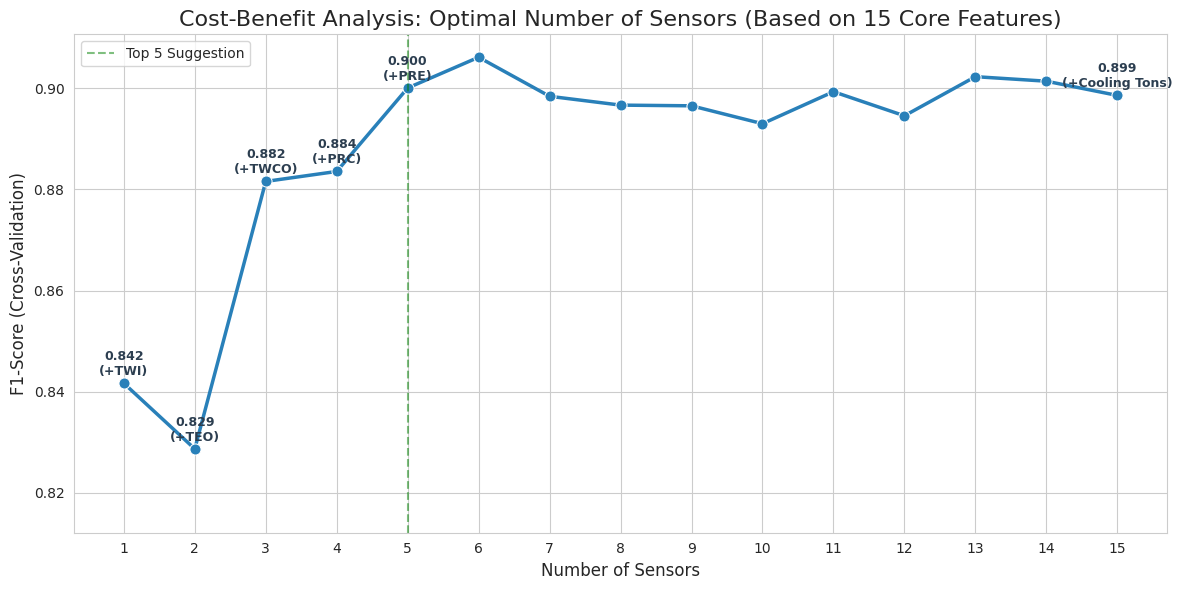


Final Recommendation (Top 5 Combination)
 Num_Sensors Added_Feature  F1_Score
           1           TWI  0.841654
           2           TEO  0.828675
           3          TWCO  0.881579
           4           PRC  0.883551
           5           PRE  0.900058


In [72]:
#Elbow method เพื่อหาจุด optimize

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from xgboost import XGBClassifier

# ==========================================
# 1. กำหนดรายชื่อ 15 Core Sensors (จากผลลัพธ์ของคุณ)
# ==========================================
core_sensors = [
    'PRE', 'TWO', 'TWCO', 'COP', 'TCI', 'TEO', 'TWI', 'TEI',
    'PRC', 'Amps', 'TWCI', 'P_lift', 'kW', 'TCO', 'Cooling Tons'
]

# เตรียมข้อมูลเฉพาะ 15 ตัวนี้ จาก Dataset 10% (Early Fault)
X_core = X_tr10[core_sensors].copy()
y_core = y_tr10.copy()

# ==========================================
# 2. จัดลำดับความสำคัญภายในกลุ่ม 15 ตัวนี้ (Re-Ranking)
# ==========================================
print("Re-ranking core sensors importance")
# ใช้ XGBoost setup เดิม
params = study_xgb10.best_params.copy()
params.update({"random_state": 42, "tree_method": "hist", "eval_metric": "logloss"})

model_ranker = XGBClassifier(**params)
model_ranker.fit(X_core, y_core)

# เรียงลำดับจากมากไปน้อย
df_rank = pd.DataFrame({
    "Feature": core_sensors,
    "Importance": model_ranker.feature_importances_
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

sorted_features = df_rank["Feature"].values
print(f"Ranking Complete. Top 3: {sorted_features[:3]}")

# ==========================================
# 3. รัน Elbow Method (Iterative Addition)
# ==========================================
results = []
print("\nStarting Cost-Benefit Analysis...")

for k in range(1, len(sorted_features) + 1):
    # เลือก k features แรก
    current_features = sorted_features[:k]
    X_subset = X_core[current_features]

    # สร้างโมเดลใหม่สำหรับรอบนี้
    model_eval = XGBClassifier(**params)

    # เรียกใช้ฟังก์ชัน cv_score_estimator_group ตัวเดิมของคุณ
    # (ต้องมั่นใจว่านิยามฟังก์ชันนี้ไว้แล้ว)
    f1, _, _, _ = cv_score_estimator_group(
        estimator=model_eval,
        X=X_subset,
        y=y_core,
        groups=groups_tr10, # ใช้ Groups เดิมของชุด 10%
        cv=cv_groups,
        model_name="xgb"
    )

    print(f"   [Sensors: {k:2d}] -> F1-Score: {f1:.4f} | Added: {current_features[-1]}")
    results.append({
        "Num_Sensors": k,
        "F1_Score": f1,
        "Added_Feature": current_features[-1]
    })

# ==========================================
# 4. พล็อตกราฟ Elbow
# ==========================================
df_results = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# วาดเส้นกราฟ
sns.lineplot(data=df_results, x="Num_Sensors", y="F1_Score", marker="o", color="#2980b9", linewidth=2.5, markersize=8)

# Highlight จุดที่เป็น Top 5
plt.axvline(x=5, color='green', linestyle='--', alpha=0.5, label='Top 5 Suggestion')

# ใส่ Label ตัวเลขกำกับจุด
for i, row in df_results.iterrows():
    # โชว์เฉพาะจุดที่ 1-5 และจุดสุดท้าย เพื่อไม่ให้รก
    if i < 5 or i == len(df_results)-1:
        plt.text(row.Num_Sensors, row.F1_Score + 0.001, f"{row.F1_Score:.3f}\n(+{row.Added_Feature})",
                 ha='center', va='bottom', fontsize=9, fontweight='bold', color='#2c3e50')

plt.title("Cost-Benefit Analysis: Optimal Number of Sensors (Based on 15 Core Features)", fontsize=16)
plt.xlabel("Number of Sensors", fontsize=12)
plt.ylabel("F1-Score (Cross-Validation)", fontsize=12)
plt.xticks(range(1, 16)) # บังคับโชว์แกน X 1-15
plt.ylim(min(df_results["F1_Score"])*0.98, max(df_results["F1_Score"])*1.005)
plt.legend()
plt.tight_layout()
plt.show()

# ==========================================
# 5. สรุปตารางแนะนำ
# ==========================================
print("\nFinal Recommendation (Top 5 Combination)")
print(df_results.head(5)[["Num_Sensors", "Added_Feature", "F1_Score"]].to_string(index=False))

In [73]:
df_results.head()

,Num_Sensors,F1_Score,Added_Feature
0,1,0.841654,TWI
1,2,0.828675,TEO
2,3,0.881579,TWCO
3,4,0.883551,PRC
4,5,0.900058,PRE


In [ ]:
#กราฟเปรียบเทียบดูไหมครับ เพื่อหา Feature Importance ของทั้ง 10% และ 40%
#ใช้ xgb (เหตุผลที่เลือกมาจาก cell block ด้านบน)

# 1. ฟังก์ชันช่วยดึงค่า Importance

def extract_importance(study, X_train, y_train, severity_label):
    # ดึง Best Params
    params = study.best_params.copy()
    # ใส่ Fixed Params ที่จำเป็น
    params.update({
        "random_state": 42,
        "tree_method": "hist", # หรือ 'auto'
        "eval_metric": "logloss"
    })

    # Retrain Model
    print(f"Training model for {severity_label} severity...")
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    # สร้าง DataFrame
    df = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": model.feature_importances_,
        "Severity": severity_label
    })
    return df

# ==========================================
# 2. ดึงข้อมูลจากทั้ง 2 กรณี (10% และ 40%)
# ==========================================
# หมายเหตุ: ต้องมั่นใจว่าคุณมีตัวแปร X_tr10, y_tr10 และ X_tr40, y_tr40 อยู่ใน Memory แล้ว

df_imp_10 = extract_importance(study_xgb10, X_tr10, y_tr10, "10% (Incipient)")
df_imp_40 = extract_importance(study_xgb40, X_tr40, y_tr40, "40% (Severe)")

# ==========================================
# 3. จัดการข้อมูลเพื่อการเปรียบเทียบ
# ==========================================
# เราจะเลือก Top 15 Features โดยยึดตาม "10% Model" เป็นหลัก
# เพื่อดูว่า Feature ที่เก่งตอน 10% มันยังสำคัญไหมตอน 40%

# หา Top 15 ของรุ่น 10%
top_features_10 = df_imp_10.sort_values(by="Importance", ascending=False).head(15)["Feature"].values

# กรองข้อมูลเอาเฉพาะ Top 15 นี้มาจากทั้งสองตาราง
df_combined = pd.concat([df_imp_10, df_imp_40])
df_subset = df_combined[df_combined["Feature"].isin(top_features_10)]

# ==========================================
# 4. พล็อตกราฟเปรียบเทียบ (Grouped Bar Chart)
# ==========================================
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

chart = sns.barplot(
    data=df_subset,
    x="Importance",
    y="Feature",
    hue="Severity",
    order=top_features_10, # บังคับเรียงตามความสำคัญของ 10%
    palette={"10% (Incipient)": "#2ecc71", "40% (Severe)": "#e74c3c"} # เขียว vs แดง
)

plt.title("Feature Importance Shift: Incipient (10%) vs. Severe (40%) Faults", fontsize=16)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature Name", fontsize=12)
plt.legend(title="Fault Severity", loc="lower right")

plt.tight_layout()
plt.show()

# ==========================================
# 5. วิเคราะห์ความเปลี่ยนแปลง (Rank Shift Analysis)
# ==========================================
print("\n=== 🔍 Insight: Significant Rank Shifts ===")
# สร้างตารางเทียบอันดับ
rank_10 = df_imp_10.sort_values(by="Importance", ascending=False).set_index("Feature")
rank_10["Rank_10"] = range(1, len(rank_10) + 1)

rank_40 = df_imp_40.sort_values(by="Importance", ascending=False).set_index("Feature")
rank_40["Rank_40"] = range(1, len(rank_40) + 1)

# รวมตาราง
comparison = rank_10[["Rank_10"]].join(rank_40[["Rank_40"]], how="inner")
comparison["Rank_Diff"] = comparison["Rank_40"] - comparison["Rank_10"]

# โชว์ตัวที่อันดับเปลี่ยนเยอะๆ (ใน Top 15 ของ 10%)
top_changes = comparison.loc[top_features_10].sort_values(by="Rank_Diff", key=abs, ascending=False).head(5)

print("Features with biggest importance shift (within Top 15 of 10% model):")
print("-" * 60)
print(f"{'Feature':<25} | {'Rank @10%':<10} | {'Rank @40%':<10} | {'Change'}")
print("-" * 60)
for feature, row in top_changes.iterrows():
    change_type = "Drop" if row['Rank_Diff'] > 0 else "Rise"
    print(f"{feature:<25} | #{int(row['Rank_10']):<9} | #{int(row['Rank_40']):<9} | {change_type} {abs(int(row['Rank_Diff']))} spots")

# Optional insight

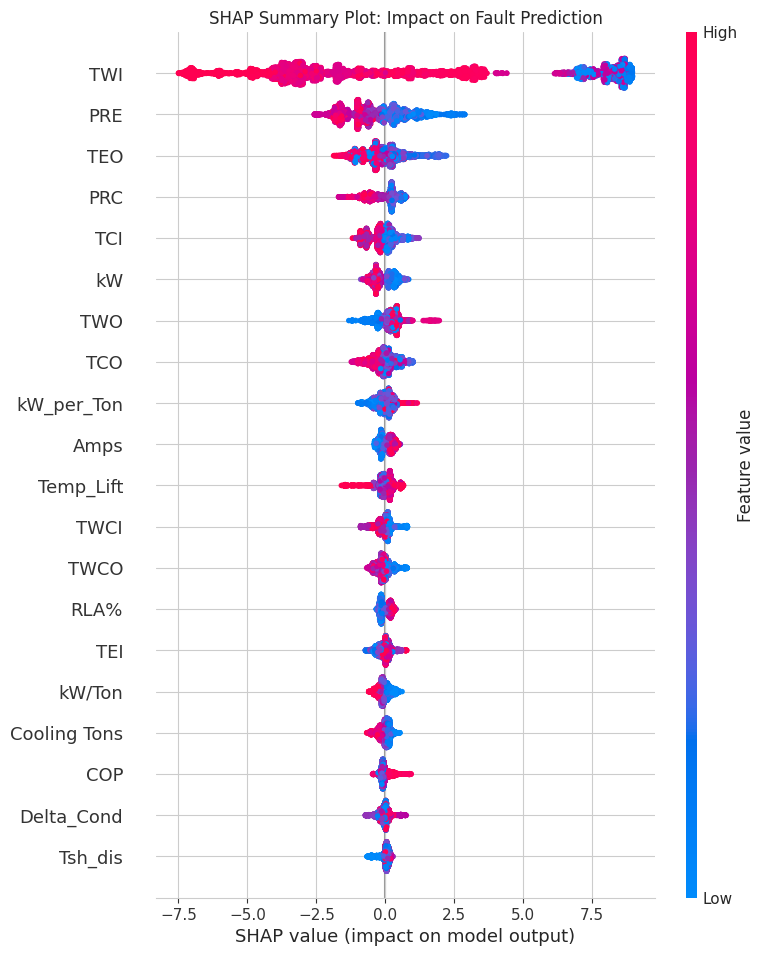

In [108]:
#แสดงผลโดย shap

import shap

# 1. สร้าง Explainer จาก Best XGB Model
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_tr10)

# 2. พล็อต SHAP Summary (Beeswarm Plot)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_tr10, show=False)
plt.title("SHAP Summary Plot: Impact on Fault Prediction")
plt.show()

Generating Cross-Validation predictions

=== Real World Performance (Cross-Validation) ===
Best Threshold (CV): 0.5321
Best F1-Score (CV):  0.9053

จากการทดสอบแบบ Cross-Validation เพื่อจำลองสถานการณ์จริง พบว่าจุดตัดสินใจที่เหมาะสมที่สุด (Optimal Threshold) 
คือ 0.5321 ซึ่งให้ค่า F1-Score สูงถึง 0.9053


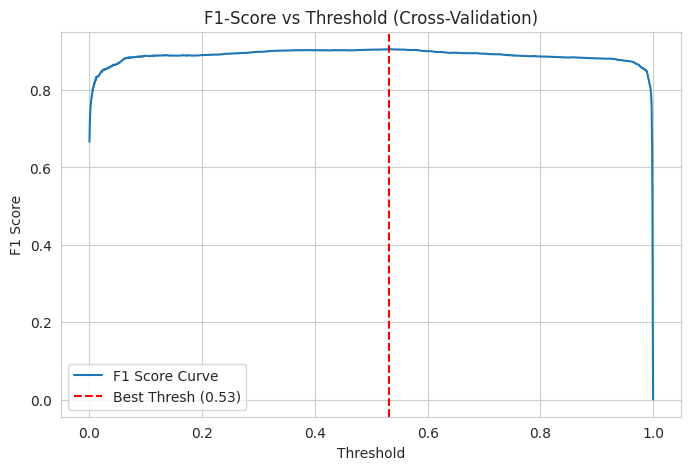

In [119]:
#Threshold tuning

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

# 1. สร้าง OOF Predictions (ทำนายแบบ Cross-Validation 5 รอบ)
# นี่คือค่า Prob ที่โมเดลทำนายตอนที่ "ไม่เคยเห็นข้อมูลนั้นมาก่อน" (เหมือนสอบจริง)
print("Generating Cross-Validation predictions")
y_oof_prob = cross_val_predict(
    best_xgb,
    X_tr10,
    y_tr10,
    cv=cv_groups,       # ใช้ตัวแบ่งกลุ่มเดิม
    groups=groups_tr10, # สำคัญ! ต้องใส่ groups
    method="predict_proba",
    n_jobs=-1
)[:, 1]

# 2. หา Best Threshold จาก OOF Predictions
precisions, recalls, thresholds = precision_recall_curve(y_tr10, y_oof_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = np.argmax(f1_scores)
best_thresh_real = thresholds[best_idx]
best_f1_real = f1_scores[best_idx]

print(f"\n=== Real World Performance (Cross-Validation) ===")
print(f"Best Threshold (CV): {best_thresh_real:.4f}")
print(f"Best F1-Score (CV):  {best_f1_real:.4f}")
print()
print("จากการทดสอบแบบ Cross-Validation เพื่อจำลองสถานการณ์จริง พบว่าจุดตัดสินใจที่เหมาะสมที่สุด (Optimal Threshold) ")
print(f"คือ {best_thresh_real:.4f} ซึ่งให้ค่า F1-Score สูงถึง {best_f1_real:.4f}")

# 3. พล็อตเปรียบเทียบ
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores[:-1], label="F1 Score Curve")
plt.axvline(best_thresh_real, color='red', linestyle='--', label=f"Best Thresh ({best_thresh_real:.2f})")
plt.title("F1-Score vs Threshold (Cross-Validation)")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

In [121]:
#Predict distribution

plt.figure(figsize=(10, 6))
sns.histplot(y_prob[y_tr10==0], color='blue', label='Normal (True)', kde=True, bins=50, alpha=0.5)
sns.histplot(y_prob[y_tr10==1], color='red', label='Fault (True)', kde=True, bins=50, alpha=0.5)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Probability of being Fault")
plt.legend()
plt.show()

NameError: name 'y_prob' is not defined

<Figure size 1000x600 with 0 Axes>

Generating predictions for XGBoost (CV)...


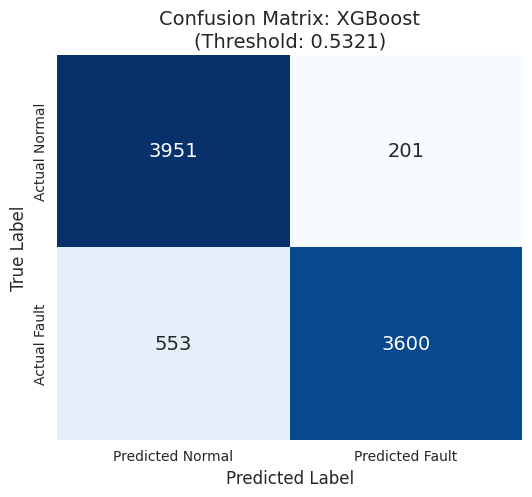

In [122]:
#หา confusion matrix จากทั้ง 3 โมเดล -> รันผล xgboost

from sklearn.metrics import confusion_matrix

# ==========================================
# 1. ฟังก์ชันสำหรับสร้างและพล็อต Confusion Matrix
# ==========================================
def plot_cv_confusion_matrix(study, model_name, X, y, groups, cv, threshold=0.5):

    # 1.1 เตรียม Best Params
    best_params = study.best_params.copy()

    # เพิ่ม Fixed Parameters (ต้องใส่ให้เหมือนตอนจูน)
    best_params.update({
        "random_state": 42,
        "eval_metric": "logloss",
        # "tree_method": "hist", # ใส่ถ้าใช้ GPU หรือข้อมูลเยอะ
        # "scale_pos_weight": ... # ใส่ถ้ามี
    })

    # 1.2 สร้างโมเดล
    if model_name == "XGBoost":
        model = XGBClassifier(**best_params)
    elif model_name == "LightGBM":
        from lightgbm import LGBMClassifier
        model = LGBMClassifier(**best_params, verbose=-1)
    elif model_name == "CatBoost":
        from catboost import CatBoostClassifier
        model = CatBoostClassifier(**best_params, verbose=False, allow_writing_files=False)

    print(f"Generating predictions for {model_name} (CV)...")

    # 1.3 ทำนายแบบ Cross-Validation (Predict Proba เพื่อปรับ Threshold ได้)
    y_oof_prob = cross_val_predict(
        model, X, y,
        cv=cv,
        groups=groups,
        method="predict_proba",
        n_jobs=-1
    )[:, 1]

    # 1.4 แปลงเป็น 0/1 ตาม Threshold
    y_pred = (y_oof_prob >= threshold).astype(int)

    # 1.5 สร้าง Confusion Matrix
    cm = confusion_matrix(y, y_pred)

    # 1.6 พล็อตกราฟสวยๆ
    plt.figure(figsize=(6, 5))

    # ใช้ Heatmap ของ Seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Normal', 'Predicted Fault'],
                yticklabels=['Actual Normal', 'Actual Fault'],
                annot_kws={"size": 14})

    plt.title(f"Confusion Matrix: {model_name}\n(Threshold: {threshold:.4f})", fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

    return cm

# ==========================================
# 2. เรียกใช้งาน (ใช้ Threshold 0.5321 ที่หาได้ล่าสุด)
# ==========================================

# สมมติว่าเราเลือก Threshold ที่ดีที่สุดจากรอบที่แล้ว
best_threshold = 0.5321

cm_xgb = plot_cv_confusion_matrix(
    study=study_xgb10,
    model_name="XGBoost",
    X=X_tr10,
    y=y_tr10,
    groups=groups_tr10,
    cv=cv_groups,
    threshold=best_threshold
)

Calculating Feature Importance
Starting Sensor Selection Experiment (Testing Top 15 features)
   Using Top 1 Sensors -> F1-Score: 0.8417
   Using Top 2 Sensors -> F1-Score: 0.8287
   Using Top 3 Sensors -> F1-Score: 0.8393
   Using Top 4 Sensors -> F1-Score: 0.8867
   Using Top 5 Sensors -> F1-Score: 0.8877
   Using Top 6 Sensors -> F1-Score: 0.8982
   Using Top 7 Sensors -> F1-Score: 0.8994
   Using Top 8 Sensors -> F1-Score: 0.8877
   Using Top 9 Sensors -> F1-Score: 0.8995
   Using Top 10 Sensors -> F1-Score: 0.8885
   Using Top 11 Sensors -> F1-Score: 0.8958
   Using Top 12 Sensors -> F1-Score: 0.8921
   Using Top 13 Sensors -> F1-Score: 0.8968
   Using Top 14 Sensors -> F1-Score: 0.8959
   Using Top 15 Sensors -> F1-Score: 0.8923


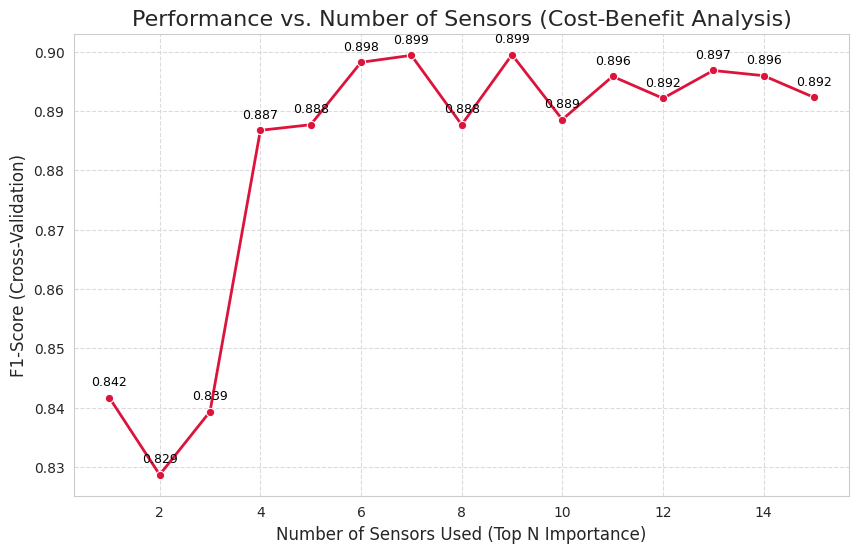


Recommended Sensor Installation Order


,Num_Sensors,F1_Score,Added_Feature
0,1,0.841654,TWI
1,2,0.828675,TEO
2,3,0.839326,PRE
3,4,0.886728,TCO
4,5,0.887673,PRC
5,6,0.898193,P_lift
6,7,0.899368,TCI
7,8,0.887675,Delta_Cond
8,9,0.899471,Temp_Lift
9,10,0.888546,TWCI


In [123]:
#cost vs performance

# 1. เตรียมโมเดลที่ดีที่สุด (ใช้ Best Params จาก Optuna)
best_params = study_xgb10.best_params
best_params.update({
    "random_state": 42,
    "tree_method": "hist",
    "eval_metric": "logloss"
})

model = XGBClassifier(**best_params)

# 2. หา Feature Importance เพื่อเรียงลำดับ "ตัวเทพ"
print("Calculating Feature Importance")
model.fit(X_tr10, y_tr10)
importances = model.feature_importances_
feature_names = X_tr10.columns

# สร้าง DataFrame และเรียงจากมากไปน้อย
df_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})
df_imp = df_imp.sort_values(by="Importance", ascending=False).reset_index(drop=True)

# 3. การทดลอง: ค่อยๆ เพิ่ม Feature ทีละตัวแล้ววัดผล (Recursive Addition)
# เราจะลองแค่ Top 15 ตัวแรกก็พอ (เพราะปกติเกิน 10 ตัวผลก็เริ่มนิ่งแล้ว)
top_n_limit = 15
results = []

print(f"Starting Sensor Selection Experiment (Testing Top {top_n_limit} features)")

for k in range(1, top_n_limit + 1):
    # เลือก k Features แรกที่เก่งที่สุด
    selected_features = df_imp["Feature"].iloc[:k].values

    # ดึงข้อมูลเฉพาะ Features ที่เลือก
    X_subset = X_tr10[selected_features]

    # วัดผลด้วย Cross-Validation (ใช้ cv_groups ตัวเดิม)
    # หมายเหตุ: ใช้ cv_groups.split ต้องระวังเรื่อง index แต่เพื่อความง่ายและเร็ว
    # เราจะใช้ cross_val_score แบบธรรมดาก่อน หรือถ้าจะให้เป๊ะต้องวนลูป cv_groups
    # แต่ในที่นี้ขอใช้วิธีเรียก function cv_score_estimator_group ที่คุณมีอยู่แล้วจะดีที่สุด

    # สร้างโมเดลใหม่สำหรับรอบนี้
    model_k = XGBClassifier(**best_params)

    f1, _, _, _ = cv_score_estimator_group(
        estimator=model_k,
        X=X_subset,
        y=y_tr10,
        groups=groups_tr10,
        cv=cv_groups,
        model_name="xgb"
    )

    print(f"   Using Top {k} Sensors -> F1-Score: {f1:.4f}")
    results.append({"Num_Sensors": k, "F1_Score": f1, "Added_Feature": selected_features[-1]})

# 4. สร้างกราฟเพื่อหาจุดคุ้มทุน (Elbow Point)
df_results = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_results, x="Num_Sensors", y="F1_Score", marker="o", color="crimson", linewidth=2)
plt.title("Performance vs. Number of Sensors (Cost-Benefit Analysis)", fontsize=16)
plt.xlabel("Number of Sensors Used (Top N Importance)", fontsize=12)
plt.ylabel("F1-Score (Cross-Validation)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Label จุดต่างๆ
for i, row in df_results.iterrows():
    plt.text(row.Num_Sensors, row.F1_Score + 0.002, f"{row.F1_Score:.3f}",
             ha='center', fontsize=9, color='black')

plt.show()

# 5. แสดงรายชื่อ Sensor ที่แนะนำ
print("\nRecommended Sensor Installation Order")
#print(df_results[["Num_Sensors", "Added_Feature", "F1_Score"]].to_string(index=False))
df_results